# **Import Lib**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

import tensorflow as tf
from tensorflow import keras

from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.models import Sequential

import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
myPath = '/content/drive/MyDrive/Topics/PL2023/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load Data**

In [ ]:
data = pd.read_csv(myPath+'data/data_under_scene.csv')
data.shape == data.dropna().shape # True: NaN data is not exist
pd.set_option('display.width', 300)
pd.options.display.float_format = '{:.4f}'.format
data

,time,temperature,humidity,precipitation,surface_wind_speed,work_day,power_load
0,2021-01-01 0:00,-4.8500,34.9300,0.0000,3.2900,1,4999.4600
1,2021-01-01 0:15,-4.8500,34.9300,0.0000,3.2900,1,4921.9430
2,2021-01-01 0:30,-4.8500,34.9300,0.0000,3.2900,1,4890.5780
3,2021-01-01 0:45,-4.8500,34.9300,0.0000,3.2900,1,4875.6560
4,2021-01-01 1:00,-4.6400,32.8200,0.0000,3.0700,1,4818.9340
...,...,...,...,...,...,...,...
35035,2021-12-31 22:45,-1.1400,66.4000,0.0000,1.7600,0,5452.1520
35036,2021-12-31 23:00,-0.8200,65.9700,0.0000,1.7300,0,5362.8360
35037,2021-12-31 23:15,-0.8200,65.9700,0.0000,1.7300,0,5267.3740
35038,2021-12-31 23:30,-0.8200,65.9700,0.0000,1.7300,0,5224.4890


# **Data processing**

In [ ]:
data.time = data.time.astype('datetime64[ns]')
timeseq = []
for x in data.time:
  timeseq.append(x.hour*60+x.minute)

In [ ]:
timeseq = pd.Series(timeseq)
timeseq = timeseq.rename("timeseq")
data = pd.concat([data, timeseq], axis=1)
print(data)

                     time  temperature  humidity  precipitation  surface_wind_speed  work_day  power_load  timeseq
0     2021-01-01 00:00:00      -4.8500   34.9300         0.0000              3.2900         1   4999.4600        0
1     2021-01-01 00:15:00      -4.8500   34.9300         0.0000              3.2900         1   4921.9430       15
2     2021-01-01 00:30:00      -4.8500   34.9300         0.0000              3.2900         1   4890.5780       30
3     2021-01-01 00:45:00      -4.8500   34.9300         0.0000              3.2900         1   4875.6560       45
4     2021-01-01 01:00:00      -4.6400   32.8200         0.0000              3.0700         1   4818.9340       60
...                   ...          ...       ...            ...                 ...       ...         ...      ...
35035 2021-12-31 22:45:00      -1.1400   66.4000         0.0000              1.7600         0   5452.1520     1365
35036 2021-12-31 23:00:00      -0.8200   65.9700         0.0000              1.7

In [ ]:
cols = data.columns.tolist()
print(cols)
cols = [cols[0], cols[-1]] + cols[1:7]
data = data[cols]

['time', 'temperature', 'humidity', 'precipitation', 'surface_wind_speed', 'work_day', 'power_load', 'timeseq']


In [ ]:
"""## Scaling Data"""
scaler = MinMaxScaler()
sdata = scaler.fit_transform(data.iloc[:,1:].to_numpy())
sdata[:,5] = (1-sdata[:,5])*.5
data.iloc[:,1:]=sdata
# scaler.inverse_transform(sdata)
print(data)

                     time  timeseq  temperature  humidity  precipitation  surface_wind_speed  work_day  power_load
0     2021-01-01 00:00:00   0.0000       0.1220    0.3360         0.0000              0.3717    0.0000      0.4231
1     2021-01-01 00:15:00   0.0105       0.1220    0.3360         0.0000              0.3717    0.0000      0.4010
2     2021-01-01 00:30:00   0.0211       0.1220    0.3360         0.0000              0.3717    0.0000      0.3921
3     2021-01-01 00:45:00   0.0316       0.1220    0.3360         0.0000              0.3717    0.0000      0.3878
4     2021-01-01 01:00:00   0.0421       0.1263    0.3144         0.0000              0.3466    0.0000      0.3716
...                   ...      ...          ...       ...            ...                 ...       ...         ...
35035 2021-12-31 22:45:00   0.9579       0.1964    0.6571         0.0000              0.1973    0.5000      0.5523
35036 2021-12-31 23:00:00   0.9684       0.2028    0.6527         0.0000        

In [ ]:
"""## SubSampling Data - sampling every hour"""
rate=4
subdata = data[::rate]
print(subdata)

                     time  timeseq  temperature  humidity  precipitation  surface_wind_speed  work_day  power_load
0     2021-01-01 00:00:00   0.0000       0.1220    0.3360         0.0000              0.3717    0.0000      0.4231
4     2021-01-01 01:00:00   0.0421       0.1263    0.3144         0.0000              0.3466    0.0000      0.3716
8     2021-01-01 02:00:00   0.0842       0.1263    0.3117         0.0000              0.3136    0.0000      0.3514
12    2021-01-01 03:00:00   0.1263       0.1152    0.3516         0.0000              0.3204    0.0000      0.3224
16    2021-01-01 04:00:00   0.1684       0.1138    0.3543         0.0000              0.3216    0.0000      0.3259
...                   ...      ...          ...       ...            ...                 ...       ...         ...
35020 2021-12-31 19:00:00   0.8000       0.2754    0.4653         0.0000              0.0593    0.5000      0.7119
35024 2021-12-31 20:00:00   0.8421       0.2435    0.5572         0.0000        

In [ ]:
subdata = subdata.reset_index()
print(subdata)

      index                time  timeseq  temperature  humidity  precipitation  surface_wind_speed  work_day  power_load
0         0 2021-01-01 00:00:00   0.0000       0.1220    0.3360         0.0000              0.3717    0.0000      0.4231
1         4 2021-01-01 01:00:00   0.0421       0.1263    0.3144         0.0000              0.3466    0.0000      0.3716
2         8 2021-01-01 02:00:00   0.0842       0.1263    0.3117         0.0000              0.3136    0.0000      0.3514
3        12 2021-01-01 03:00:00   0.1263       0.1152    0.3516         0.0000              0.3204    0.0000      0.3224
4        16 2021-01-01 04:00:00   0.1684       0.1138    0.3543         0.0000              0.3216    0.0000      0.3259
...     ...                 ...      ...          ...       ...            ...                 ...       ...         ...
8755  35020 2021-12-31 19:00:00   0.8000       0.2754    0.4653         0.0000              0.0593    0.5000      0.7119
8756  35024 2021-12-31 20:00:00 

In [ ]:
subdata.to_csv(myPath+'data/data_minmax_scale.csv')

In [ ]:
period_train = ('2021-01-01 00:00:00','2021-10-31 23:45:00')
period_test = ('2021-11-01 00:00:00', '2021-12-31 23:45:00')
data_train = subdata[subdata.time.between(period_train[0], period_train[1])]
data_test = subdata[subdata.time.between(period_test[0], period_test[1])]
X_train = data_train.to_numpy()
X_test = data_test.to_numpy()

In [ ]:
Y_train = data_train.power_load
Y_test = data_test.power_load
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(7296, 9) (7296,)
(1464, 9) (1464,)


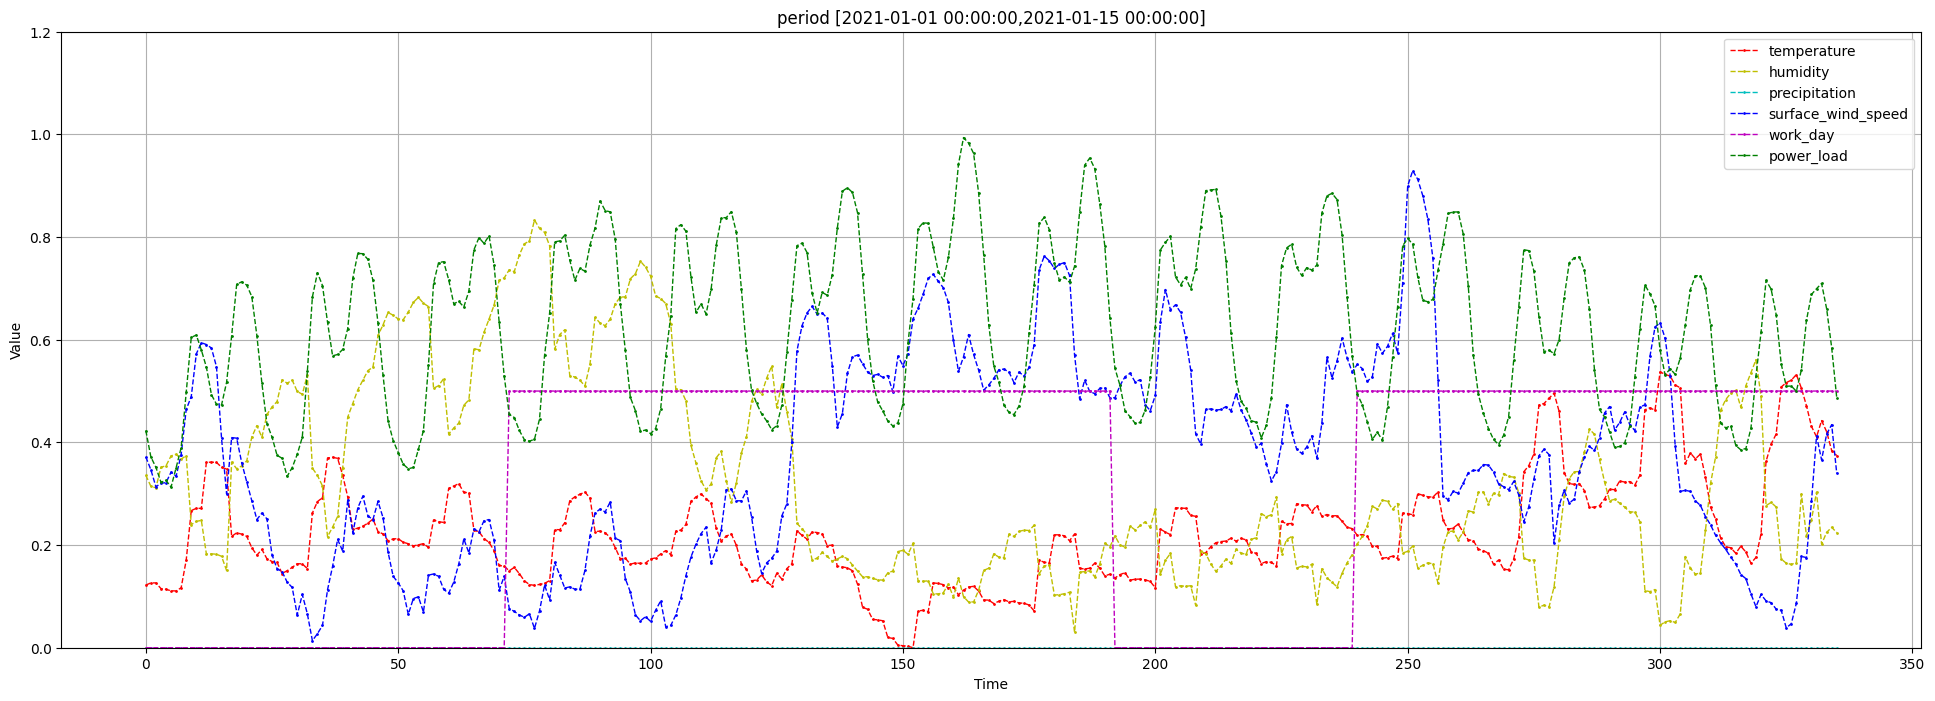

In [ ]:
i0 = 24*30*0
i1 = i0+24*14
features = cols
markColors = ['r.--', 'y.--', 'c.--', 'b.--', 'm.--', 'g.--']
plt.rcParams['figure.figsize'] = [24, 8]
for j in range(6):
  plt.plot(data_train[features[j+2]][i0:i1], markColors[j], label=features[j+2], linewidth=1, markersize=2)
plt.title('period [' + str(data.iloc[4*i0].time)+','+str(data.iloc[4*i1].time)+']')
plt.xticks(rotation=0)
plt.ylabel('Value')
plt.xlabel('Time')
plt.ylim([0, 1.2])
plt.grid(True)
plt.legend()
plt.show()

# **Split and Multiframe**

In [ ]:
"""## Multiframe data setup"""
"""## 365 * 24 * 4=35,040, 365 * 24=8,760 trainging data set count 305 * 24=7,320"""
def split_sequences(sequences, n_steps, n_prediction):
  X = list();
  n = len(sequences)-n_steps-n_prediction+1
  for i in range(n):
    x = sequences[i:i+n_steps,:]
    X.append(x)
  return array(X)

In [ ]:
cols = data.columns.tolist()
print(cols)

['time', 'timeseq', 'temperature', 'humidity', 'precipitation', 'surface_wind_speed', 'work_day', 'power_load']


In [ ]:
#features =['timeseq','temperature','humidity','surface_wind_speed','work_day','power_load']
features =['timeseq','temperature','humidity','precipitation','surface_wind_speed','work_day','power_load']
target = 'power_load'
X_train = data_train.loc[:, features].to_numpy()
X_test = data_test.loc[:,features].to_numpy()
n_features = len(features)

In [ ]:
print(X_train.shape)
print(X_train)

(7296, 7)
[[0.0000 0.1220 0.3360 0.0000 0.3717 0.0000 0.4231]
 [0.0421 0.1263 0.3144 0.0000 0.3466 0.0000 0.3716]
 [0.0842 0.1263 0.3117 0.0000 0.3136 0.0000 0.3514]
 [0.1263 0.1152 0.3516 0.0000 0.3204 0.0000 0.3224]
 [0.1684 0.1138 0.3543 0.0000 0.3216 0.0000 0.3259]
 [0.2105 0.1108 0.3737 0.0000 0.3421 0.0000 0.3128]
 [0.2526 0.1106 0.3768 0.0000 0.3341 0.0000 0.3505]
 [0.2947 0.1168 0.3674 0.0000 0.3763 0.0000 0.3898]
 [0.3368 0.1705 0.3742 0.0000 0.4641 0.0000 0.4982]
 [0.3789 0.2671 0.2398 0.0000 0.4892 0.0000 0.6045]
 ...
 [0.5895 0.5976 0.5258 0.0000 0.2315 0.0000 0.3563]
 [0.6316 0.5828 0.5706 0.0000 0.1756 0.0000 0.3486]
 [0.6737 0.5868 0.5865 0.0000 0.1220 0.0000 0.3705]
 [0.7158 0.5104 0.7015 0.0000 0.0821 0.0000 0.4344]
 [0.7579 0.5158 0.7169 0.0000 0.0684 0.0000 0.4731]
 [0.8000 0.5158 0.7586 0.0000 0.1072 0.0000 0.4406]
 [0.8421 0.5088 0.7977 0.0000 0.1391 0.0000 0.4314]
 [0.8842 0.5190 0.7442 0.0000 0.2486 0.0000 0.4162]
 [0.9263 0.4826 0.7689 0.0000 0.2828 0.0000 0.356

In [ ]:
Y_train = data_train.power_load
Y_test = data_test.power_load

In [ ]:
print(Y_train.to_numpy())

[0.4231 0.3716 0.3514 0.3224 0.3259 0.3128 0.3505 0.3898 0.4982 0.6045 ... 0.3563 0.3486 0.3705 0.4344 0.4731 0.4406 0.4314
 0.4162 0.3563 0.2852]


# **Set parameters**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_steps_1 = 4  # Squence data (48 = 1 day), (720 = 15days), (1440 = 30days)
n_prediction_1 = 1

n_steps_2 = 10
n_prediction_2 = 3

n_steps_3 = 12
n_prediction_3 = 5

np.set_printoptions(edgeitems=10, linewidth=130, formatter=dict(float=lambda x: "%6.4f" % x))

In [ ]:
print(X_train, X_train.shape)
print(Y_train)

[[0.0000 0.1220 0.3360 0.0000 0.3717 0.0000 0.4231]
 [0.0421 0.1263 0.3144 0.0000 0.3466 0.0000 0.3716]
 [0.0842 0.1263 0.3117 0.0000 0.3136 0.0000 0.3514]
 [0.1263 0.1152 0.3516 0.0000 0.3204 0.0000 0.3224]
 [0.1684 0.1138 0.3543 0.0000 0.3216 0.0000 0.3259]
 [0.2105 0.1108 0.3737 0.0000 0.3421 0.0000 0.3128]
 [0.2526 0.1106 0.3768 0.0000 0.3341 0.0000 0.3505]
 [0.2947 0.1168 0.3674 0.0000 0.3763 0.0000 0.3898]
 [0.3368 0.1705 0.3742 0.0000 0.4641 0.0000 0.4982]
 [0.3789 0.2671 0.2398 0.0000 0.4892 0.0000 0.6045]
 ...
 [0.5895 0.5976 0.5258 0.0000 0.2315 0.0000 0.3563]
 [0.6316 0.5828 0.5706 0.0000 0.1756 0.0000 0.3486]
 [0.6737 0.5868 0.5865 0.0000 0.1220 0.0000 0.3705]
 [0.7158 0.5104 0.7015 0.0000 0.0821 0.0000 0.4344]
 [0.7579 0.5158 0.7169 0.0000 0.0684 0.0000 0.4731]
 [0.8000 0.5158 0.7586 0.0000 0.1072 0.0000 0.4406]
 [0.8421 0.5088 0.7977 0.0000 0.1391 0.0000 0.4314]
 [0.8842 0.5190 0.7442 0.0000 0.2486 0.0000 0.4162]
 [0.9263 0.4826 0.7689 0.0000 0.2828 0.0000 0.3563]
 [0.968

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=4, n_prediction=1):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.n_prediction = n_prediction
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i < self.X.shape[0] - (self.sequence_length + self.n_prediction):
            x = self.X[i:(i + self.sequence_length), :]
        else:
            i = self.X.shape[0] - (self.sequence_length + self.n_prediction)
            x = self.X[i:(i + self.sequence_length), :]
        return x, self.y[i + self.sequence_length + self.n_prediction - 1]

In [ ]:
batch_size = 200
train_dataset1 = SequenceDataset(
    data_train,
    target=target,
    features=features,
    sequence_length=n_steps_1,
    n_prediction = n_prediction_1
)
test_dataset1 = SequenceDataset(
    data_test,
    target=target,
    features=features,
    sequence_length=n_steps_1,
    n_prediction = n_prediction_1
)

train_dataset2 = SequenceDataset(
    data_train,
    target=target,
    features=features,
    sequence_length=n_steps_2,
    n_prediction = n_prediction_2
)
test_dataset2 = SequenceDataset(
    data_test,
    target=target,
    features=features,
    sequence_length=n_steps_2,
    n_prediction = n_prediction_2
)

train_dataset3 = SequenceDataset(
    data_train,
    target=target,
    features=features,
    sequence_length=n_steps_3,
    n_prediction = n_prediction_3
)
test_dataset3 = SequenceDataset(
    data_test,
    target=target,
    features=features,
    sequence_length=n_steps_3,
    n_prediction = n_prediction_3
)
train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)
X1, y1 = next(iter(train_loader1))

print("Features shape:", X1.shape)
print("Target shape:", y1.shape)

train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)
X2, y2 = next(iter(train_loader2))

print("Features shape:", X2.shape)
print("Target shape:", y2.shape)

train_loader3 = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True)
test_loader3 = DataLoader(test_dataset3, batch_size=batch_size, shuffle=False)
X3, y3 = next(iter(train_loader3))

print("Features shape:", X3.shape)
print("Target shape:", y3.shape)


Features shape: torch.Size([200, 4, 7])
Target shape: torch.Size([200])
Features shape: torch.Size([200, 10, 7])
Target shape: torch.Size([200])
Features shape: torch.Size([200, 12, 7])
Target shape: torch.Size([200])


# **Self_Attention Model**

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size  # this is the number of features in the input data at each time step
        self.hidden_size = hidden_size  # this is the hidden units in LSTM layer
        self.num_layers = num_layers  # this is the number of LSTM layers
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size, num_layers=self.num_layers, batch_first=True)
          # batch_first= True: input data will have the batch size as the first dimension

        self.linear = nn.Linear(in_features=self.hidden_size, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        return out

In [ ]:
class SelfAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        # Linear layer
        self.emss = nn.Linear(input_dim, hidden_dim)
        # Attention layer
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=num_heads)
        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Attention mechanism
        features = self.emss(x)
        features = features.permute(1, 0, 2)
        query = torch.mean(features, dim=0, keepdim=True)
        #query = query.permute(1, 0, 2)
        attention_output, _ = self.attention(query, features, features)
        # Output layer
        out = self.fc(attention_output.squeeze(0)).flatten()
        return out

In [ ]:
class LSTM_SelfAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, num_heads=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # Attention layer
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=num_heads)
        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # Forward propagation LSTM
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Attention mechanism
        features = out.permute(1, 0, 2)
        query = torch.mean(features, dim=0, keepdim=True)
        #query = query.permute(1, 0, 2)

        attention_output, _ = self.attention(query, features, features)
        # Output layer
        out = self.fc(attention_output.squeeze(0)).flatten()
        return out

# **Training**

In [ ]:
input_size =  len(features)
output_size = 1
hidden_units = 8
hidden_units_group = [8]
num_layers = 1 # Hidden layer # 10 3 # 6
dropout_prob = 0.5
learning_rate = 0.002

case_name = 'LSTM_nn_'+str(hidden_units)+'_ln_'+str(num_layers) # case name for graph

In [ ]:
train_losses_1 = []
validation_losses_1 = []

train_losses_2 = []
validation_losses_2 = []

train_losses_3 = []
validation_losses_3 = []

train_losses_4 = []
validation_losses_4 = []

train_losses_5 = []
validation_losses_5 = []

train_losses_6 = []
validation_losses_6 = []

train_losses_7 = []
validation_losses_7 = []

train_losses_8 = []
validation_losses_8 = []

train_losses_9 = []
validation_losses_9 = []

best_val_loss = float('inf')

loss_function = nn.MSELoss()

epochs = 600

In [ ]:
train_losses_1 = []
validation_losses_1 = []
def train_model(data_loader, model, loss_function,train_losses,optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / num_batches
    train_losses.append(avg_loss)
    print(f"Train loss: %6.4f  " % avg_loss, end="")

def test_model(data_loader, model, loss_function,validation_losses):
    num_batches = len(data_loader)
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            # print(X, y)
            output = model(X)
            total_loss += loss_function(output, y).item()
    avg_loss = total_loss / num_batches
    validation_losses.append(avg_loss)
    print(f"Test loss: %6.4f" % avg_loss)

In [ ]:
train_losses_1 = []
validation_losses_1 = []
model_LSTM_Model1= LSTMModel(input_size=input_size, hidden_size=hidden_units, num_layers=num_layers).to(device)

optimizer1 = torch.optim.Adam(model_LSTM_Model1.parameters(), lr=learning_rate)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader1, model_LSTM_Model1, loss_function, train_losses_1,optimizer=optimizer1)
    test_model(test_loader1, model_LSTM_Model1, loss_function,validation_losses_1)


torch.save(model_LSTM_Model1.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp1_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp1_MSE.pth')

Epoch 0 Train loss: 0.2948  Test loss: 0.0647
Epoch 1 Train loss: 0.0188  Test loss: 0.0144
Epoch 2 Train loss: 0.0135  Test loss: 0.0147
Epoch 3 Train loss: 0.0129  Test loss: 0.0145
Epoch 4 Train loss: 0.0121  Test loss: 0.0140
Epoch 5 Train loss: 0.0114  Test loss: 0.0134
Epoch 6 Train loss: 0.0106  Test loss: 0.0130
Epoch 7 Train loss: 0.0097  Test loss: 0.0120
Epoch 8 Train loss: 0.0087  Test loss: 0.0112
Epoch 9 Train loss: 0.0076  Test loss: 0.0102
Epoch 10 Train loss: 0.0064  Test loss: 0.0091
Epoch 11 Train loss: 0.0053  Test loss: 0.0077
Epoch 12 Train loss: 0.0046  Test loss: 0.0069
Epoch 13 Train loss: 0.0040  Test loss: 0.0063
Epoch 14 Train loss: 0.0037  Test loss: 0.0059
Epoch 15 Train loss: 0.0036  Test loss: 0.0057
Epoch 16 Train loss: 0.0035  Test loss: 0.0054
Epoch 17 Train loss: 0.0033  Test loss: 0.0053
Epoch 18 Train loss: 0.0032  Test loss: 0.0051
Epoch 19 Train loss: 0.0031  Test loss: 0.0049
Epoch 20 Train loss: 0.0030  Test loss: 0.0048
Epoch 21 Train loss: 0.

In [ ]:
train_losses_2 = []
validation_losses_2 = []
model_LSTM_Model2= LSTMModel(input_size=input_size, hidden_size=hidden_units, num_layers=num_layers).to(device)

optimizer2 = torch.optim.Adam(model_LSTM_Model2.parameters(), lr=learning_rate)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader2, model_LSTM_Model2, loss_function, train_losses_2,optimizer=optimizer2)
    test_model(test_loader2, model_LSTM_Model2, loss_function,validation_losses_2)


torch.save(model_LSTM_Model2.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp2_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp2_MSE.pth')

Epoch 0 Train loss: 0.0612  Test loss: 0.0178
Epoch 1 Train loss: 0.0190  Test loss: 0.0180
Epoch 2 Train loss: 0.0171  Test loss: 0.0172
Epoch 3 Train loss: 0.0152  Test loss: 0.0163
Epoch 4 Train loss: 0.0128  Test loss: 0.0140
Epoch 5 Train loss: 0.0096  Test loss: 0.0111
Epoch 6 Train loss: 0.0067  Test loss: 0.0078
Epoch 7 Train loss: 0.0057  Test loss: 0.0077
Epoch 8 Train loss: 0.0053  Test loss: 0.0078
Epoch 9 Train loss: 0.0051  Test loss: 0.0077
Epoch 10 Train loss: 0.0050  Test loss: 0.0077
Epoch 11 Train loss: 0.0049  Test loss: 0.0078
Epoch 12 Train loss: 0.0048  Test loss: 0.0080
Epoch 13 Train loss: 0.0047  Test loss: 0.0078
Epoch 14 Train loss: 0.0046  Test loss: 0.0073
Epoch 15 Train loss: 0.0044  Test loss: 0.0072
Epoch 16 Train loss: 0.0043  Test loss: 0.0070
Epoch 17 Train loss: 0.0042  Test loss: 0.0071
Epoch 18 Train loss: 0.0041  Test loss: 0.0068
Epoch 19 Train loss: 0.0039  Test loss: 0.0067
Epoch 20 Train loss: 0.0038  Test loss: 0.0065
Epoch 21 Train loss: 0.

In [ ]:
train_losses_3 = []
validation_losses_3 = []
model_LSTM_Model3= LSTMModel(input_size=input_size, hidden_size=hidden_units, num_layers=num_layers).to(device)

optimizer3 = torch.optim.Adam(model_LSTM_Model3.parameters(), lr=learning_rate)

scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader3, model_LSTM_Model3, loss_function, train_losses_3,optimizer=optimizer3)
    test_model(test_loader3, model_LSTM_Model3, loss_function,validation_losses_3)


torch.save(model_LSTM_Model3.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp3_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp3_MSE.pth')

Epoch 0 Train loss: 0.1009  Test loss: 0.0229
Epoch 1 Train loss: 0.0214  Test loss: 0.0219
Epoch 2 Train loss: 0.0192  Test loss: 0.0203
Epoch 3 Train loss: 0.0178  Test loss: 0.0185
Epoch 4 Train loss: 0.0147  Test loss: 0.0156
Epoch 5 Train loss: 0.0087  Test loss: 0.0104
Epoch 6 Train loss: 0.0061  Test loss: 0.0083
Epoch 7 Train loss: 0.0054  Test loss: 0.0074
Epoch 8 Train loss: 0.0052  Test loss: 0.0069
Epoch 9 Train loss: 0.0050  Test loss: 0.0067
Epoch 10 Train loss: 0.0048  Test loss: 0.0069
Epoch 11 Train loss: 0.0047  Test loss: 0.0064
Epoch 12 Train loss: 0.0046  Test loss: 0.0061
Epoch 13 Train loss: 0.0045  Test loss: 0.0059
Epoch 14 Train loss: 0.0044  Test loss: 0.0060
Epoch 15 Train loss: 0.0043  Test loss: 0.0057
Epoch 16 Train loss: 0.0043  Test loss: 0.0060
Epoch 17 Train loss: 0.0042  Test loss: 0.0057
Epoch 18 Train loss: 0.0041  Test loss: 0.0053
Epoch 19 Train loss: 0.0040  Test loss: 0.0054
Epoch 20 Train loss: 0.0039  Test loss: 0.0053
Epoch 21 Train loss: 0.

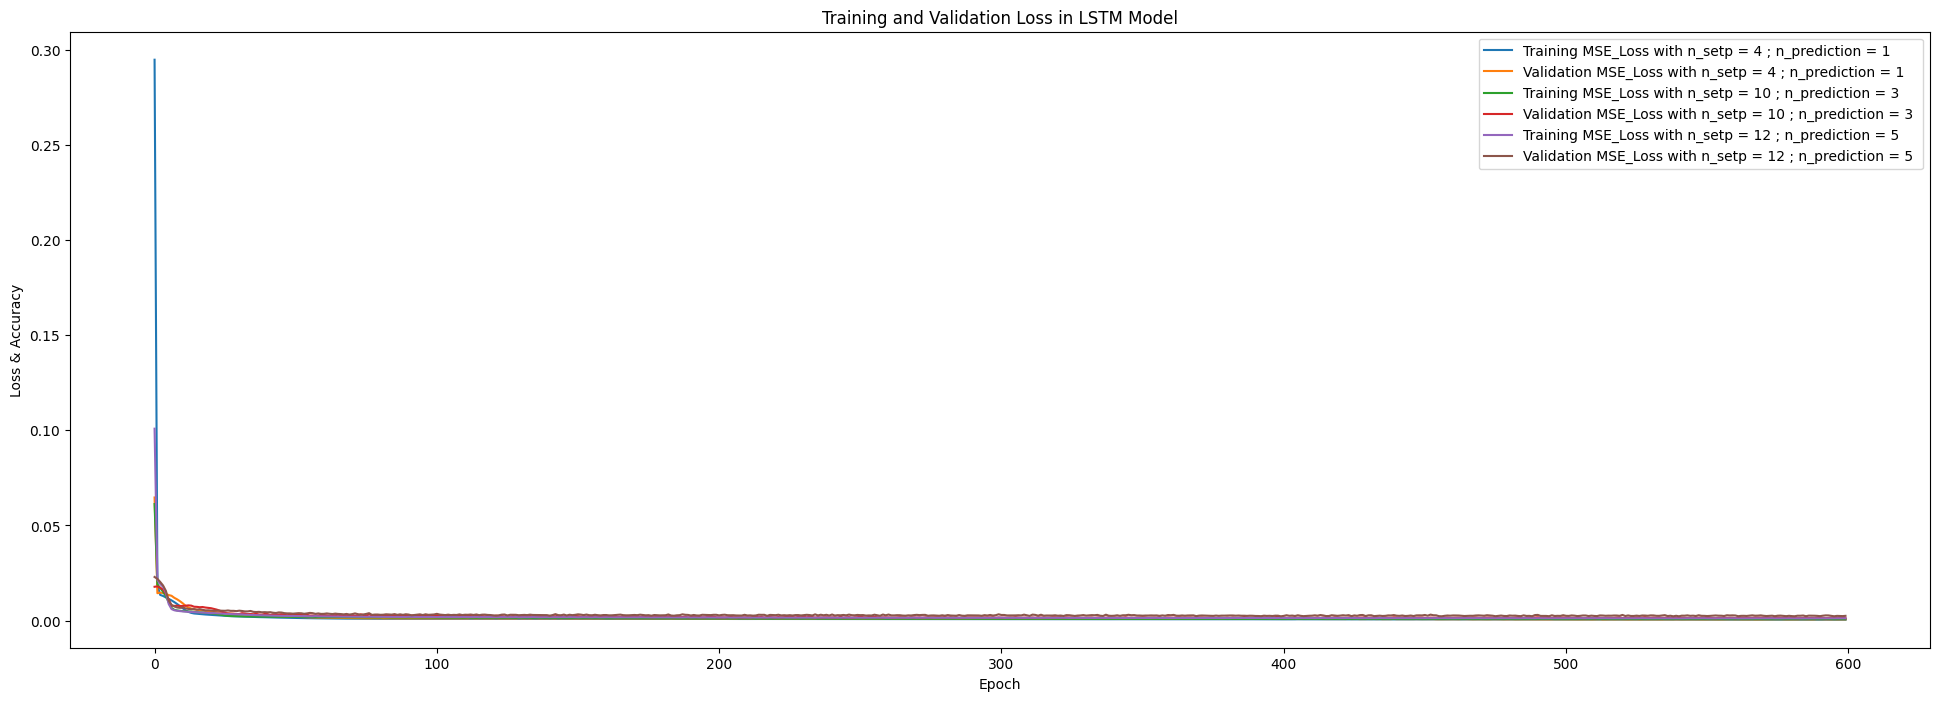

In [ ]:
plt.figure()
plt.plot(train_losses_1, label='Training MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(validation_losses_1, label='Validation MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(train_losses_2, label='Training MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(validation_losses_2, label='Validation MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(train_losses_3, label='Training MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.plot(validation_losses_3, label='Validation MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.title('Training and Validation Loss in LSTM Model')
plt.legend()
plt.show()

In [ ]:
train_losses_4 = []
validation_losses_4 = []
model_LSTM_SelfAttentionModel1= LSTM_SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units, num_layers=num_layers, output_dim=output_size,num_heads=8).to(device)

optimizer1 = torch.optim.Adam(model_LSTM_SelfAttentionModel1.parameters(), lr=learning_rate)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader1, model_LSTM_SelfAttentionModel1, loss_function, train_losses_4,optimizer=optimizer1)
    test_model(test_loader1, model_LSTM_SelfAttentionModel1, loss_function,validation_losses_4)


torch.save(model_LSTM_SelfAttentionModel1.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp1_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp1_MSE.pth')

Epoch 0 Train loss: 0.2832  Test loss: 0.0164
Epoch 1 Train loss: 0.0200  Test loss: 0.0181
Epoch 2 Train loss: 0.0138  Test loss: 0.0177
Epoch 3 Train loss: 0.0127  Test loss: 0.0169
Epoch 4 Train loss: 0.0114  Test loss: 0.0157
Epoch 5 Train loss: 0.0099  Test loss: 0.0130
Epoch 6 Train loss: 0.0079  Test loss: 0.0102
Epoch 7 Train loss: 0.0061  Test loss: 0.0091
Epoch 8 Train loss: 0.0052  Test loss: 0.0081
Epoch 9 Train loss: 0.0049  Test loss: 0.0077
Epoch 10 Train loss: 0.0046  Test loss: 0.0074
Epoch 11 Train loss: 0.0043  Test loss: 0.0070
Epoch 12 Train loss: 0.0041  Test loss: 0.0066
Epoch 13 Train loss: 0.0039  Test loss: 0.0063
Epoch 14 Train loss: 0.0036  Test loss: 0.0059
Epoch 15 Train loss: 0.0034  Test loss: 0.0056
Epoch 16 Train loss: 0.0032  Test loss: 0.0052
Epoch 17 Train loss: 0.0030  Test loss: 0.0048
Epoch 18 Train loss: 0.0029  Test loss: 0.0044
Epoch 19 Train loss: 0.0026  Test loss: 0.0041
Epoch 20 Train loss: 0.0024  Test loss: 0.0038
Epoch 21 Train loss: 0.

In [ ]:
train_losses_5 = []
validation_losses_5 = []
model_LSTM_SelfAttentionModel2= LSTM_SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units, num_layers=num_layers, output_dim=output_size,num_heads=8).to(device)

optimizer2 = torch.optim.Adam(model_LSTM_SelfAttentionModel2.parameters(), lr=learning_rate)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader2, model_LSTM_SelfAttentionModel2, loss_function, train_losses_5,optimizer=optimizer2)
    test_model(test_loader2, model_LSTM_SelfAttentionModel2, loss_function,validation_losses_5)


torch.save(model_LSTM_SelfAttentionModel2.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp2_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp2_MSE.pth')

Epoch 0 Train loss: 0.0224  Test loss: 0.0188
Epoch 1 Train loss: 0.0209  Test loss: 0.0184
Epoch 2 Train loss: 0.0168  Test loss: 0.0135
Epoch 3 Train loss: 0.0073  Test loss: 0.0083
Epoch 4 Train loss: 0.0062  Test loss: 0.0079
Epoch 5 Train loss: 0.0056  Test loss: 0.0072
Epoch 6 Train loss: 0.0051  Test loss: 0.0068
Epoch 7 Train loss: 0.0045  Test loss: 0.0056
Epoch 8 Train loss: 0.0039  Test loss: 0.0050
Epoch 9 Train loss: 0.0036  Test loss: 0.0044
Epoch 10 Train loss: 0.0034  Test loss: 0.0043
Epoch 11 Train loss: 0.0032  Test loss: 0.0039
Epoch 12 Train loss: 0.0031  Test loss: 0.0039
Epoch 13 Train loss: 0.0030  Test loss: 0.0044
Epoch 14 Train loss: 0.0029  Test loss: 0.0038
Epoch 15 Train loss: 0.0028  Test loss: 0.0036
Epoch 16 Train loss: 0.0028  Test loss: 0.0036
Epoch 17 Train loss: 0.0027  Test loss: 0.0036
Epoch 18 Train loss: 0.0026  Test loss: 0.0032
Epoch 19 Train loss: 0.0026  Test loss: 0.0031
Epoch 20 Train loss: 0.0025  Test loss: 0.0031
Epoch 21 Train loss: 0.

In [ ]:
train_losses_6 = []
validation_losses_6 = []
model_LSTM_SelfAttentionModel3= LSTM_SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units, num_layers=num_layers, output_dim=output_size,num_heads=8).to(device)

optimizer3 = torch.optim.Adam(model_LSTM_SelfAttentionModel3.parameters(), lr=learning_rate)

scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader3, model_LSTM_SelfAttentionModel3, loss_function, train_losses_6,optimizer=optimizer3)
    test_model(test_loader3, model_LSTM_SelfAttentionModel3, loss_function,validation_losses_6)


torch.save(model_LSTM_SelfAttentionModel3.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp3_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp3_MSE.pth')

Epoch 0 Train loss: 0.0518  Test loss: 0.0189
Epoch 1 Train loss: 0.0217  Test loss: 0.0188
Epoch 2 Train loss: 0.0208  Test loss: 0.0192
Epoch 3 Train loss: 0.0190  Test loss: 0.0165
Epoch 4 Train loss: 0.0136  Test loss: 0.0132
Epoch 5 Train loss: 0.0086  Test loss: 0.0095
Epoch 6 Train loss: 0.0065  Test loss: 0.0076
Epoch 7 Train loss: 0.0059  Test loss: 0.0070
Epoch 8 Train loss: 0.0055  Test loss: 0.0065
Epoch 9 Train loss: 0.0053  Test loss: 0.0065
Epoch 10 Train loss: 0.0050  Test loss: 0.0060
Epoch 11 Train loss: 0.0048  Test loss: 0.0057
Epoch 12 Train loss: 0.0046  Test loss: 0.0058
Epoch 13 Train loss: 0.0044  Test loss: 0.0053
Epoch 14 Train loss: 0.0042  Test loss: 0.0052
Epoch 15 Train loss: 0.0040  Test loss: 0.0049
Epoch 16 Train loss: 0.0037  Test loss: 0.0043
Epoch 17 Train loss: 0.0034  Test loss: 0.0038
Epoch 18 Train loss: 0.0033  Test loss: 0.0034
Epoch 19 Train loss: 0.0031  Test loss: 0.0032
Epoch 20 Train loss: 0.0029  Test loss: 0.0031
Epoch 21 Train loss: 0.

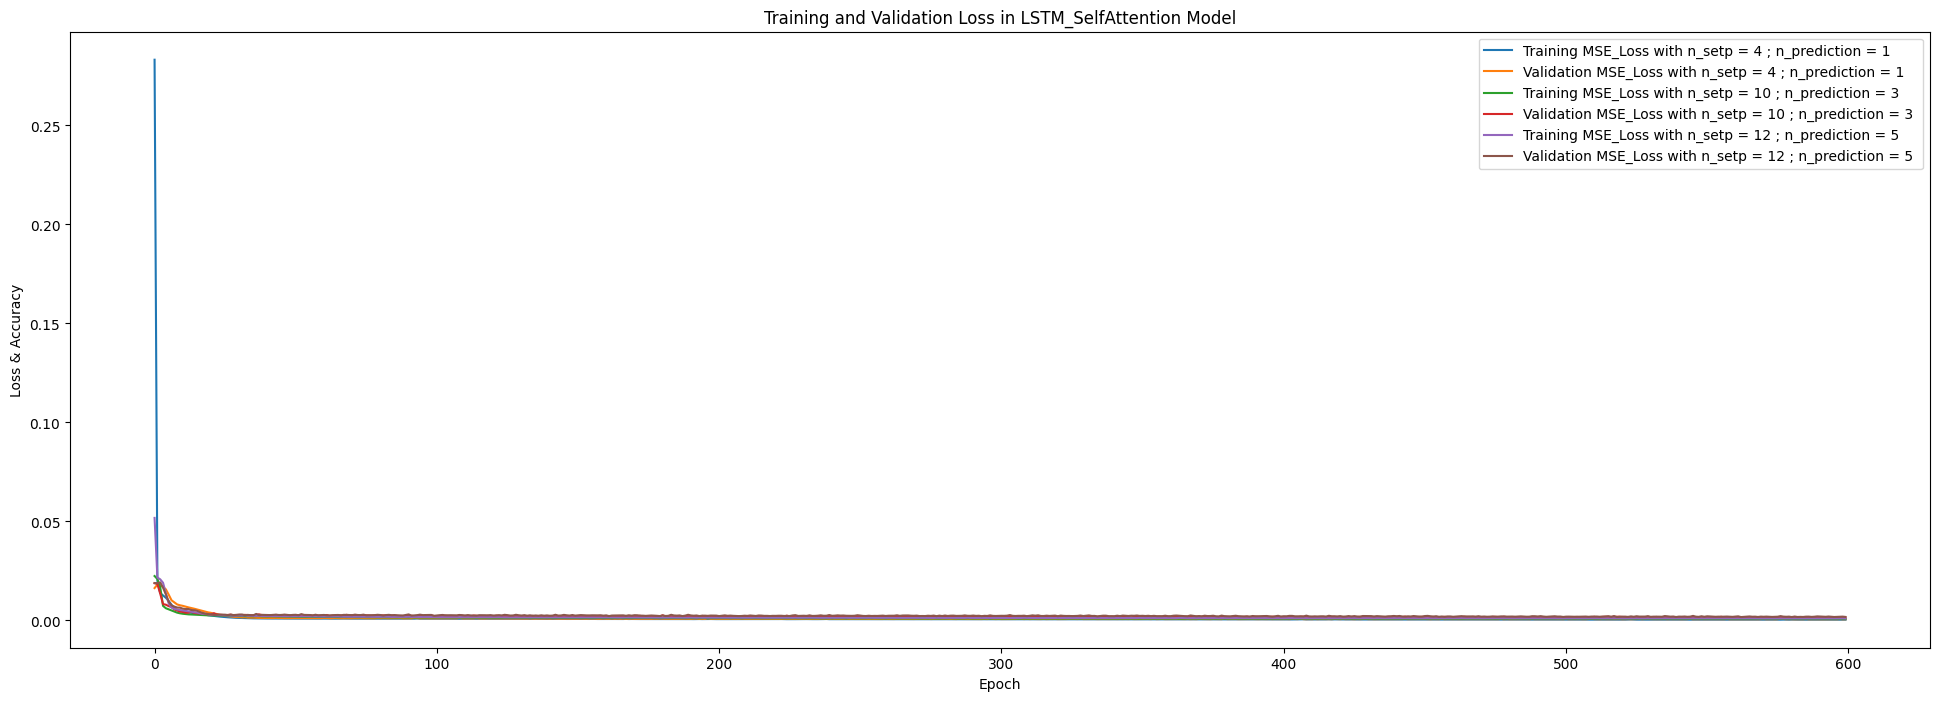

In [ ]:
plt.figure()
plt.plot(train_losses_4, label='Training MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(validation_losses_4, label='Validation MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(train_losses_5, label='Training MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(validation_losses_5, label='Validation MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(train_losses_6, label='Training MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.plot(validation_losses_6, label='Validation MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.title('Training and Validation Loss in LSTM_SelfAttention Model')
plt.legend()
plt.show()

In [ ]:
train_losses_7 = []
validation_losses_7 = []
model_SelfAttentionModel1= SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units, output_dim=output_size,num_heads=8).to(device)

optimizer1 = torch.optim.Adam(model_SelfAttentionModel1.parameters(), lr=learning_rate)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader1, model_SelfAttentionModel1, loss_function, train_losses_7,optimizer=optimizer1)
    test_model(test_loader1, model_SelfAttentionModel1, loss_function,validation_losses_7)


torch.save(model_SelfAttentionModel1.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp1_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp1_MSE.pth')

Epoch 0 Train loss: 0.0300  Test loss: 0.0155
Epoch 1 Train loss: 0.0134  Test loss: 0.0125
Epoch 2 Train loss: 0.0094  Test loss: 0.0100
Epoch 3 Train loss: 0.0065  Test loss: 0.0090
Epoch 4 Train loss: 0.0053  Test loss: 0.0075
Epoch 5 Train loss: 0.0049  Test loss: 0.0073
Epoch 6 Train loss: 0.0046  Test loss: 0.0069
Epoch 7 Train loss: 0.0044  Test loss: 0.0067
Epoch 8 Train loss: 0.0043  Test loss: 0.0069
Epoch 9 Train loss: 0.0042  Test loss: 0.0064
Epoch 10 Train loss: 0.0042  Test loss: 0.0063
Epoch 11 Train loss: 0.0040  Test loss: 0.0062
Epoch 12 Train loss: 0.0039  Test loss: 0.0058
Epoch 13 Train loss: 0.0038  Test loss: 0.0055
Epoch 14 Train loss: 0.0035  Test loss: 0.0052
Epoch 15 Train loss: 0.0033  Test loss: 0.0049
Epoch 16 Train loss: 0.0031  Test loss: 0.0044
Epoch 17 Train loss: 0.0028  Test loss: 0.0040
Epoch 18 Train loss: 0.0026  Test loss: 0.0037
Epoch 19 Train loss: 0.0024  Test loss: 0.0033
Epoch 20 Train loss: 0.0023  Test loss: 0.0031
Epoch 21 Train loss: 0.

In [ ]:
train_losses_8 = []
validation_losses_8 = []
model_SelfAttentionModel2= SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units,output_dim=output_size,num_heads=8).to(device)

optimizer2 = torch.optim.Adam(model_SelfAttentionModel2.parameters(), lr=learning_rate)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader2, model_SelfAttentionModel2, loss_function, train_losses_8,optimizer=optimizer2)
    test_model(test_loader2, model_SelfAttentionModel2, loss_function,validation_losses_8)


torch.save(model_SelfAttentionModel2.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp2_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp2_MSE.pth')

Epoch 0 Train loss: 0.0558  Test loss: 0.0236
Epoch 1 Train loss: 0.0202  Test loss: 0.0230
Epoch 2 Train loss: 0.0190  Test loss: 0.0216
Epoch 3 Train loss: 0.0178  Test loss: 0.0209
Epoch 4 Train loss: 0.0162  Test loss: 0.0183
Epoch 5 Train loss: 0.0140  Test loss: 0.0159
Epoch 6 Train loss: 0.0112  Test loss: 0.0126
Epoch 7 Train loss: 0.0083  Test loss: 0.0098
Epoch 8 Train loss: 0.0067  Test loss: 0.0090
Epoch 9 Train loss: 0.0064  Test loss: 0.0086
Epoch 10 Train loss: 0.0063  Test loss: 0.0089
Epoch 11 Train loss: 0.0062  Test loss: 0.0086
Epoch 12 Train loss: 0.0062  Test loss: 0.0089
Epoch 13 Train loss: 0.0062  Test loss: 0.0086
Epoch 14 Train loss: 0.0060  Test loss: 0.0084
Epoch 15 Train loss: 0.0060  Test loss: 0.0082
Epoch 16 Train loss: 0.0059  Test loss: 0.0085
Epoch 17 Train loss: 0.0059  Test loss: 0.0080
Epoch 18 Train loss: 0.0058  Test loss: 0.0085
Epoch 19 Train loss: 0.0058  Test loss: 0.0082
Epoch 20 Train loss: 0.0057  Test loss: 0.0079
Epoch 21 Train loss: 0.

In [ ]:
train_losses_9 = []
validation_losses_9 = []
model_SelfAttentionModel3= SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units, output_dim=output_size,num_heads=8).to(device)

optimizer3 = torch.optim.Adam(model_SelfAttentionModel3.parameters(), lr=learning_rate)

scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader3, model_SelfAttentionModel3, loss_function, train_losses_9,optimizer=optimizer3)
    test_model(test_loader3, model_SelfAttentionModel3, loss_function,validation_losses_9)


torch.save(model_SelfAttentionModel3.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp3_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp3_MSE.pth')

Epoch 0 Train loss: 0.0205  Test loss: 0.0203
Epoch 1 Train loss: 0.0133  Test loss: 0.0157
Epoch 2 Train loss: 0.0075  Test loss: 0.0080
Epoch 3 Train loss: 0.0060  Test loss: 0.0072
Epoch 4 Train loss: 0.0057  Test loss: 0.0074
Epoch 5 Train loss: 0.0056  Test loss: 0.0069
Epoch 6 Train loss: 0.0052  Test loss: 0.0063
Epoch 7 Train loss: 0.0049  Test loss: 0.0058
Epoch 8 Train loss: 0.0048  Test loss: 0.0057
Epoch 9 Train loss: 0.0047  Test loss: 0.0052
Epoch 10 Train loss: 0.0045  Test loss: 0.0051
Epoch 11 Train loss: 0.0045  Test loss: 0.0049
Epoch 12 Train loss: 0.0043  Test loss: 0.0050
Epoch 13 Train loss: 0.0042  Test loss: 0.0052
Epoch 14 Train loss: 0.0041  Test loss: 0.0048
Epoch 15 Train loss: 0.0040  Test loss: 0.0048
Epoch 16 Train loss: 0.0040  Test loss: 0.0049
Epoch 17 Train loss: 0.0039  Test loss: 0.0049
Epoch 18 Train loss: 0.0038  Test loss: 0.0048
Epoch 19 Train loss: 0.0038  Test loss: 0.0044
Epoch 20 Train loss: 0.0038  Test loss: 0.0046
Epoch 21 Train loss: 0.

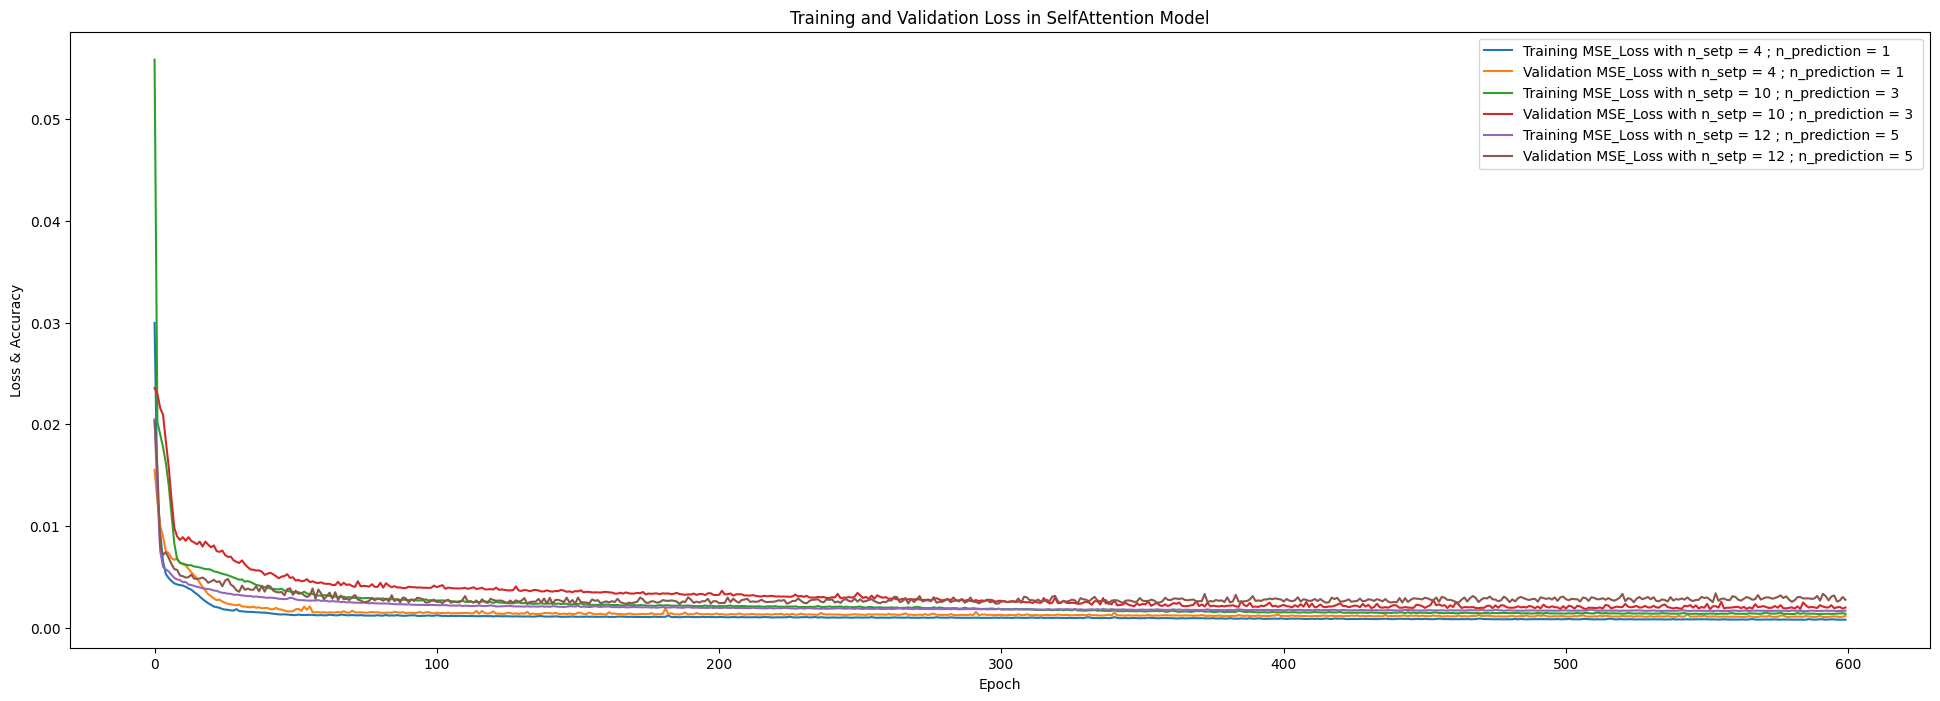

In [ ]:
plt.figure()
plt.plot(train_losses_7, label='Training MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(validation_losses_7, label='Validation MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(train_losses_8, label='Training MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(validation_losses_8, label='Validation MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(train_losses_9, label='Training MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.plot(validation_losses_9, label='Validation MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.title('Training and Validation Loss in SelfAttention Model')
plt.legend()
plt.show()

# **Prediction result**

In [ ]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

In [ ]:
Y_train1 = data_train.power_load
rY_train1 = np.roll(Y_train1, -(n_steps_1 + n_prediction_1-1))
rY_train1[-(n_steps_1+n_prediction_1-1):] = 0

Y_train2 = data_train.power_load
rY_train2 = np.roll(Y_train1, -(n_steps_2 + n_prediction_2-1))
rY_train2[-(n_steps_2+n_prediction_2-1):] = 0

Y_train3 = data_train.power_load
rY_train3 = np.roll(Y_train1, -(n_steps_3 + n_prediction_3-1))
rY_train3[-(n_steps_3+n_prediction_3-1):] = 0

print(Y_train1)
print(rY_train1)
print(Y_train2)
print(rY_train2)
print(Y_train3)
print(rY_train3)

0      0.4231
1      0.3716
2      0.3514
3      0.3224
4      0.3259
        ...  
7291   0.4406
7292   0.4314
7293   0.4162
7294   0.3563
7295   0.2852
Name: power_load, Length: 7296, dtype: float64
[0.3259 0.3128 0.3505 0.3898 0.4982 0.6045 0.6092 0.5800 0.5465 0.4929 ... 0.4731 0.4406 0.4314 0.4162 0.3563 0.2852 0.0000
 0.0000 0.0000 0.0000]
0      0.4231
1      0.3716
2      0.3514
3      0.3224
4      0.3259
        ...  
7291   0.4406
7292   0.4314
7293   0.4162
7294   0.3563
7295   0.2852
Name: power_load, Length: 7296, dtype: float64
[0.5465 0.4929 0.4743 0.4729 0.5170 0.6072 0.7077 0.7129 0.7063 0.6840 ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.0000]
0      0.4231
1      0.3716
2      0.3514
3      0.3224
4      0.3259
        ...  
7291   0.4406
7292   0.4314
7293   0.4162
7294   0.3563
7295   0.2852
Name: power_load, Length: 7296, dtype: float64
[0.5170 0.6072 0.7077 0.7129 0.7063 0.6840 0.6081 0.5148 0.4365 0.4104 ... 0.0000 0.0000 0.0000 0.0000 

In [ ]:
Y_test1 = data_test.power_load
rY_test1 = np.roll(Y_test1, -(n_steps_1 + n_prediction_1-1))
rY_test1[-(n_steps_1 + n_prediction_1 - 1):] = 0

Y_test2 = data_test.power_load
rY_test2 = np.roll(Y_test2, -(n_steps_2 + n_prediction_2-1))
rY_test2[-(n_steps_2 + n_prediction_2 - 1):] = 0

Y_test3 = data_test.power_load
rY_test3 = np.roll(Y_test3, -(n_steps_3 + n_prediction_3-1))
rY_test3[-(n_steps_3 + n_prediction_3 - 1):] = 0

print(Y_test1)
print(rY_test1)
print(Y_test2)
print(rY_test2)
print(Y_test3)
print(rY_test3)

7296   0.2499
7297   0.2542
7298   0.2366
7299   0.2172
7300   0.2325
        ...  
8755   0.7119
8756   0.7195
8757   0.6841
8758   0.6121
8759   0.5268
Name: power_load, Length: 1464, dtype: float64
[0.2325 0.2388 0.2842 0.3710 0.3582 0.3878 0.4055 0.4151 0.3435 0.2802 ... 0.7540 0.7119 0.7195 0.6841 0.6121 0.5268 0.0000
 0.0000 0.0000 0.0000]
7296   0.2499
7297   0.2542
7298   0.2366
7299   0.2172
7300   0.2325
        ...  
8755   0.7119
8756   0.7195
8757   0.6841
8758   0.6121
8759   0.5268
Name: power_load, Length: 1464, dtype: float64
[0.3435 0.2802 0.3562 0.3602 0.4030 0.4752 0.4825 0.4392 0.4294 0.4241 ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.0000]
7296   0.2499
7297   0.2542
7298   0.2366
7299   0.2172
7300   0.2325
        ...  
8755   0.7119
8756   0.7195
8757   0.6841
8758   0.6121
8759   0.5268
Name: power_load, Length: 1464, dtype: float64
[0.4030 0.4752 0.4825 0.4392 0.4294 0.4241 0.3704 0.3128 0.2673 0.2698 ... 0.0000 0.0000 0.0000 0.0000 

In [ ]:
ystar_col = "Model forecast"
train_eval_loader1 = DataLoader(train_dataset1, batch_size=100, shuffle=False)
train_eval_loader2 = DataLoader(train_dataset2, batch_size=100, shuffle=False)
train_eval_loader3 = DataLoader(train_dataset3, batch_size=100, shuffle=False)

dt_train1 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test1 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train2 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test2 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train3 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test3 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train4 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test4 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train5 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test5 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train6 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test6 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train7 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test7 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train8 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test8 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train9 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test9 = subdata[subdata.time.between(period_test[0], period_test[1])]


dt_train1[ystar_col] = predict(train_eval_loader1, model_LSTM_Model1).numpy()
dt_test1[ystar_col] = predict(test_loader1, model_LSTM_Model1).numpy()
dt_train2[ystar_col] = predict(train_eval_loader2, model_LSTM_Model2).numpy()
dt_test2[ystar_col] = predict(test_loader2, model_LSTM_Model2).numpy()
dt_train3[ystar_col] = predict(train_eval_loader3, model_LSTM_Model3).numpy()
dt_test3[ystar_col] = predict(test_loader3, model_LSTM_Model3).numpy()
dt_train4[ystar_col] = predict(train_eval_loader1, model_LSTM_SelfAttentionModel1).numpy()
dt_test4[ystar_col] = predict(test_loader1, model_LSTM_SelfAttentionModel1).numpy()
dt_train5[ystar_col] = predict(train_eval_loader2, model_LSTM_SelfAttentionModel2).numpy()
dt_test5[ystar_col] = predict(test_loader2, model_LSTM_SelfAttentionModel2).numpy()
dt_train6[ystar_col] = predict(train_eval_loader3, model_LSTM_SelfAttentionModel3).numpy()
dt_test6[ystar_col] = predict(test_loader3, model_LSTM_SelfAttentionModel3).numpy()
dt_train7[ystar_col] = predict(train_eval_loader1, model_SelfAttentionModel1).numpy()
dt_test7[ystar_col] = predict(test_loader1, model_SelfAttentionModel1).numpy()
dt_train8[ystar_col] = predict(train_eval_loader2, model_SelfAttentionModel2).numpy()
dt_test8[ystar_col] = predict(test_loader2, model_SelfAttentionModel2).numpy()
dt_train9[ystar_col] = predict(train_eval_loader3, model_SelfAttentionModel3).numpy()
dt_test9[ystar_col] = predict(test_loader3, model_SelfAttentionModel3).numpy()


n1 = 500
n2 = n1+batch_size

print(rY_train1[n1 :n2])
print(rY_train2[n1 :n2])
print(rY_train3[n1 :n2])
print(dt_train1[ystar_col][n1 :n2])
print(dt_train2[ystar_col][n1 :n2])
print(dt_train3[ystar_col][n1 :n2])
print(dt_train4[ystar_col][n1 :n2])
print(dt_train5[ystar_col][n1 :n2])
print(dt_train6[ystar_col][n1 :n2])
print(dt_train7[ystar_col][n1 :n2])
print(dt_train8[ystar_col][n1 :n2])
print(dt_train9[ystar_col][n1 :n2])
print(rY_test1[n1 :n2])
print(rY_test2[n1 :n2])
print(rY_test3[n1 :n2])
print(dt_test1[ystar_col][n1 :n2])
print(dt_test2[ystar_col][n1 :n2])
print(dt_test3[ystar_col][n1 :n2])
print(dt_test4[ystar_col][n1 :n2])
print(dt_test5[ystar_col][n1 :n2])
print(dt_test6[ystar_col][n1 :n2])
print(dt_test7[ystar_col][n1 :n2])
print(dt_test8[ystar_col][n1 :n2])
print(dt_test9[ystar_col][n1 :n2])

<ipython-input-213-f4f2226357de>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_train1[ystar_col] = predict(train_eval_loader1, model_LSTM_Model1).numpy()
<ipython-input-213-f4f2226357de>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_test1[ystar_col] = predict(test_loader1, model_LSTM_Model1).numpy()
<ipython-input-213-f4f2226357de>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

[0.3721 0.3528 0.3298 0.3117 0.3021 0.3078 0.3456 0.4235 0.5509 0.6694 0.6661 0.6632 0.5791 0.5423 0.5320 0.5368 0.5510 0.6092
 0.6532 0.6410 0.6143 0.5786 0.4945 0.3795 0.2980 0.2733 0.2414 0.2223 0.2250 0.2205 0.2555 0.2960 0.4312 0.5350 0.5390 0.5534
 0.4998 0.4379 0.4302 0.4220 0.4533 0.5531 0.6061 0.5960 0.5731 0.5380 0.4721 0.3589 0.2765 0.2512 0.2346 0.2267 0.2138 0.2122
 0.2278 0.2788 0.3780 0.5061 0.5606 0.6122 0.5965 0.5575 0.5441 0.5218 0.5264 0.6066 0.6536 0.6350 0.6201 0.5526 0.4610 0.3643
 0.2932 0.2504 0.2273 0.2297 0.2178 0.2227 0.2511 0.3124 0.4452 0.5712 0.6278 0.6446 0.5923 0.5258 0.5149 0.5250 0.5286 0.5901
 0.6272 0.6251 0.6029 0.5572 0.4785 0.3848 0.3098 0.2774 0.2546 0.2384 0.2394 0.2333 0.2839 0.3314 0.4720 0.5674 0.5172 0.5223
 0.4763 0.4113 0.4000 0.4046 0.4385 0.5185 0.6024 0.6208 0.6191 0.5796 0.5326 0.4153 0.3561 0.3411 0.3135 0.2844 0.2835 0.2866
 0.3188 0.3789 0.5092 0.6229 0.6542 0.6849 0.6145 0.5182 0.5114 0.4913 0.5087 0.5927 0.6433 0.6566 0.6260 0.592

<ipython-input-213-f4f2226357de>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_train9[ystar_col] = predict(train_eval_loader3, model_SelfAttentionModel3).numpy()
<ipython-input-213-f4f2226357de>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_test9[ystar_col] = predict(test_loader3, model_SelfAttentionModel3).numpy()


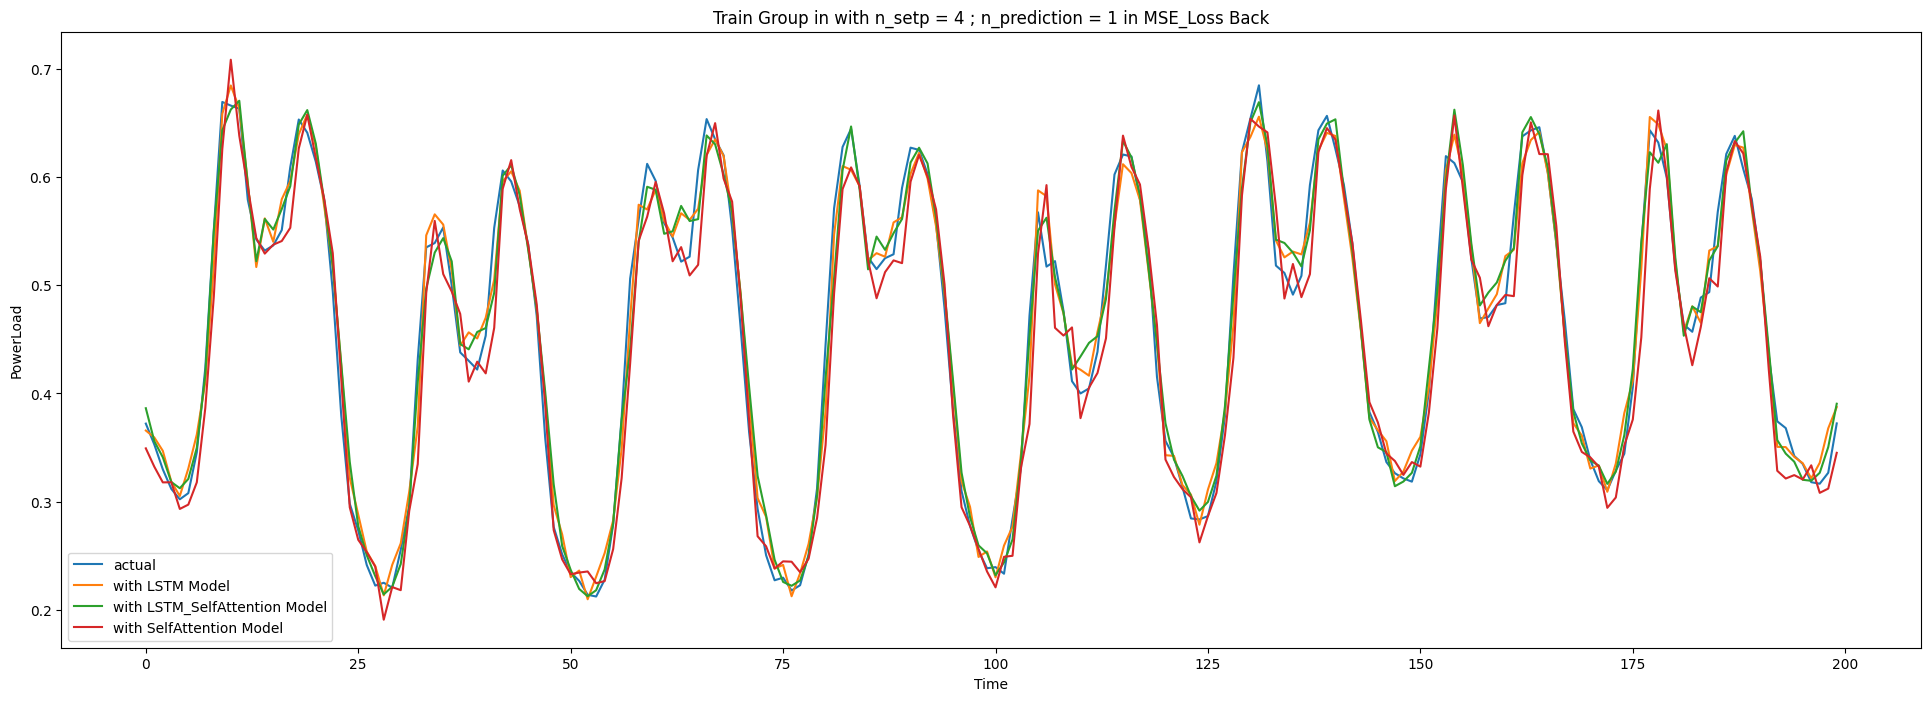

In [ ]:
plt.plot(rY_train1[n1 :n2], label='actual' )
plt.plot(dt_train1[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_train4[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_train7[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Train Group in with n_setp = 4 ; n_prediction = 1 in MSE_Loss Back' )
plt.legend()
plt.show()

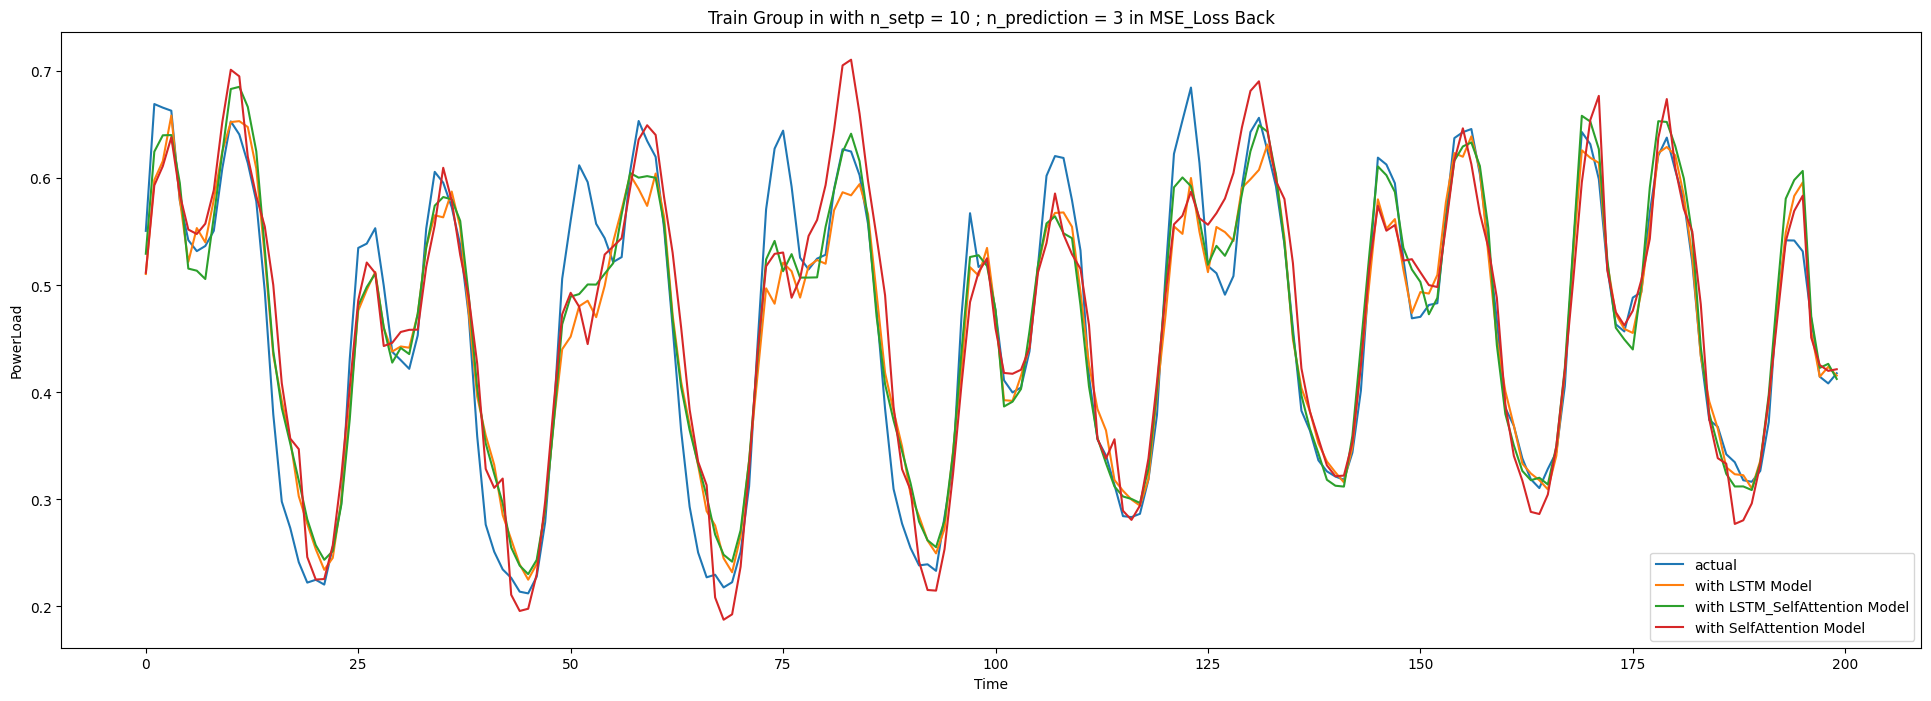

In [ ]:
plt.plot(rY_train2[n1 :n2], label='actual' )
plt.plot(dt_train2[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_train5[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_train8[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Train Group in with n_setp = 10 ; n_prediction = 3 in MSE_Loss Back' )
plt.legend()
plt.show()

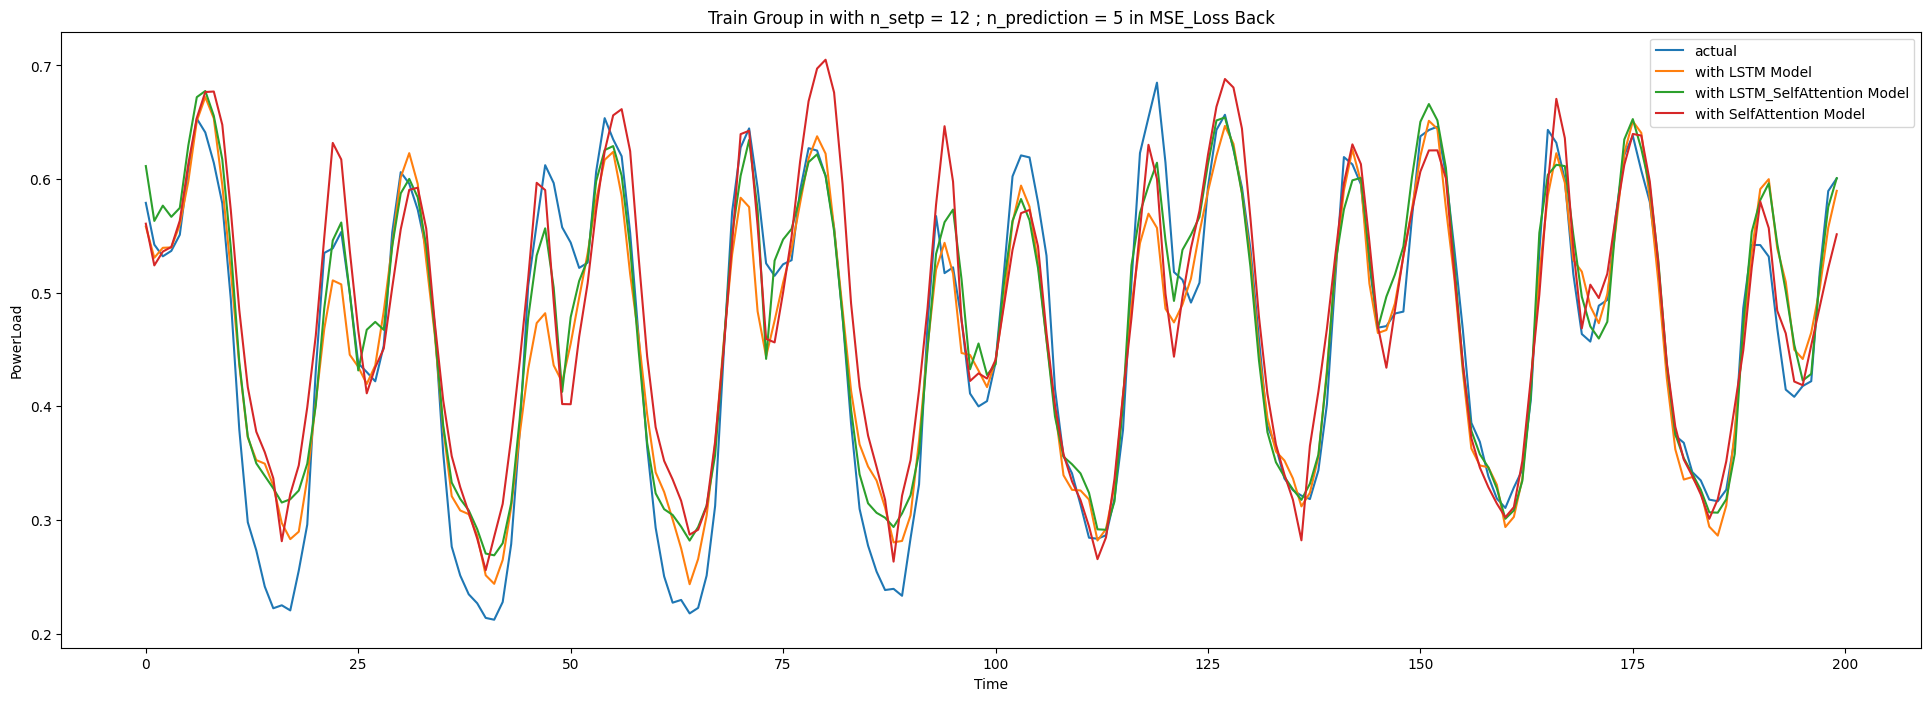

In [ ]:
plt.plot(rY_train3[n1 :n2], label='actual' )
plt.plot(dt_train3[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_train6[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_train9[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Train Group in with n_setp = 12 ; n_prediction = 5 in MSE_Loss Back')
plt.legend()
plt.show()

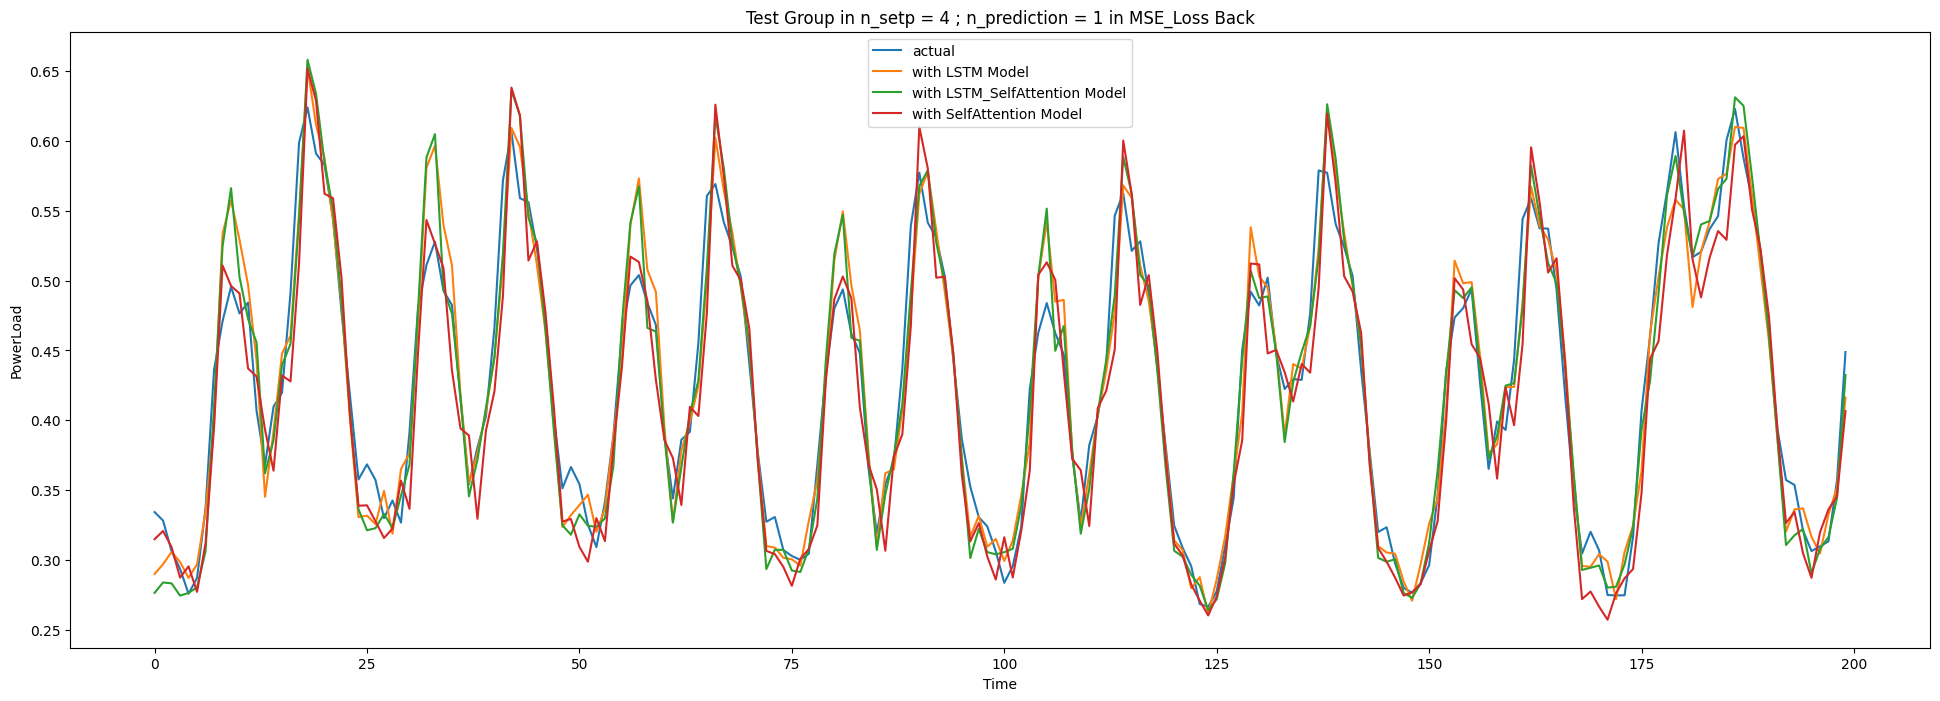

In [ ]:
plt.plot(rY_test1[n1 :n2], label='actual' )
plt.plot(dt_test1[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_test4[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_test7[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Test Group in n_setp = 4 ; n_prediction = 1 in MSE_Loss Back')
plt.legend()
plt.show()

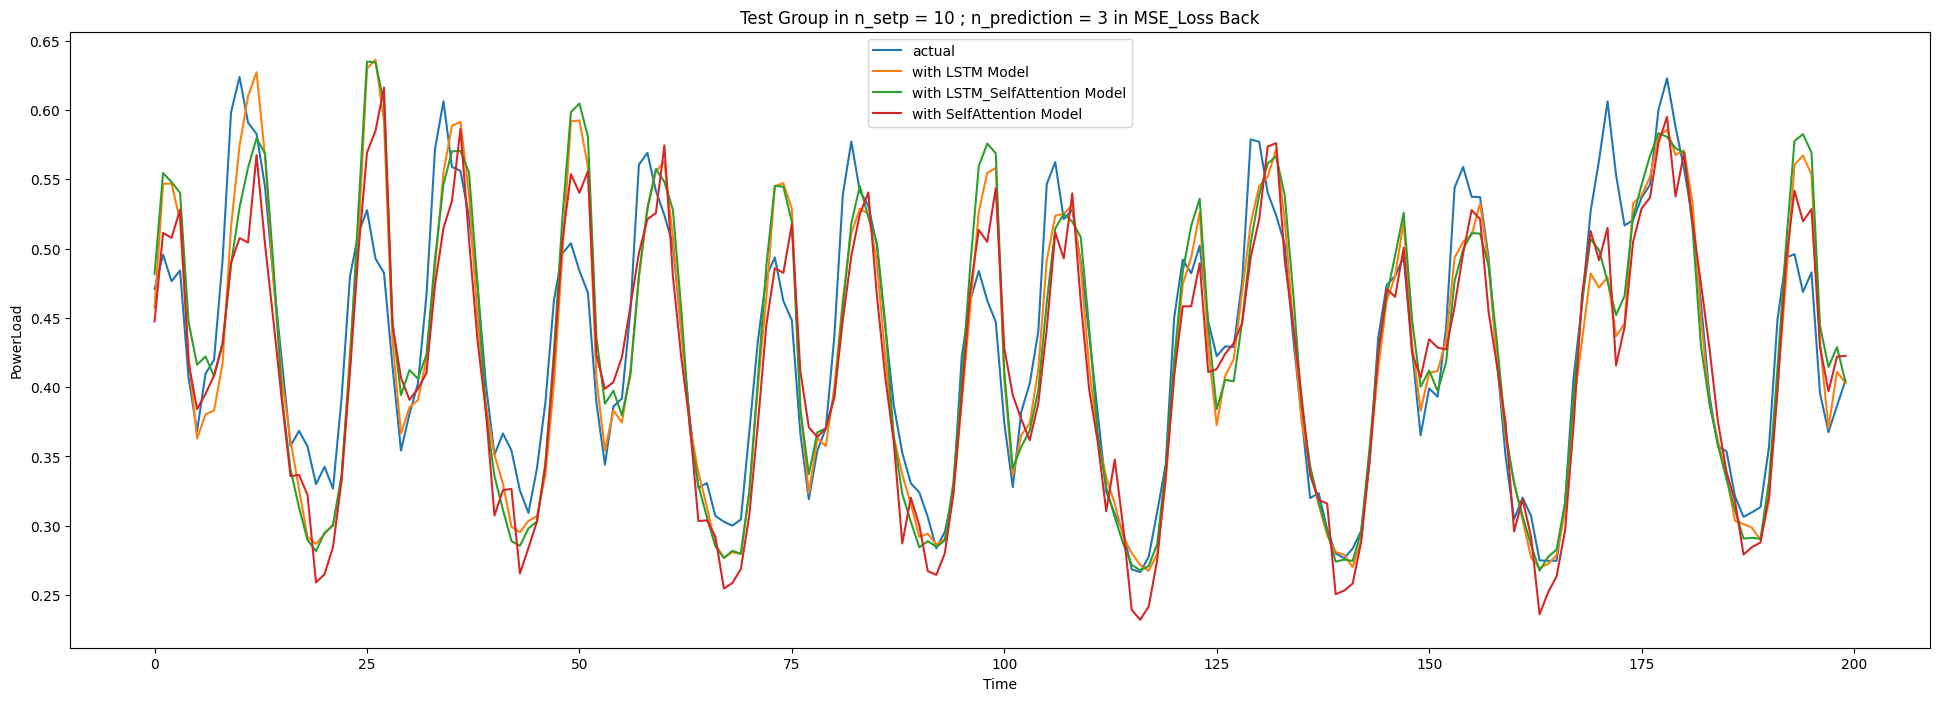

In [ ]:
plt.plot(rY_test2[n1 :n2], label='actual' )
plt.plot(dt_test2[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_test5[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_test8[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Test Group in n_setp = 10 ; n_prediction = 3 in MSE_Loss Back')
plt.legend()
plt.show()

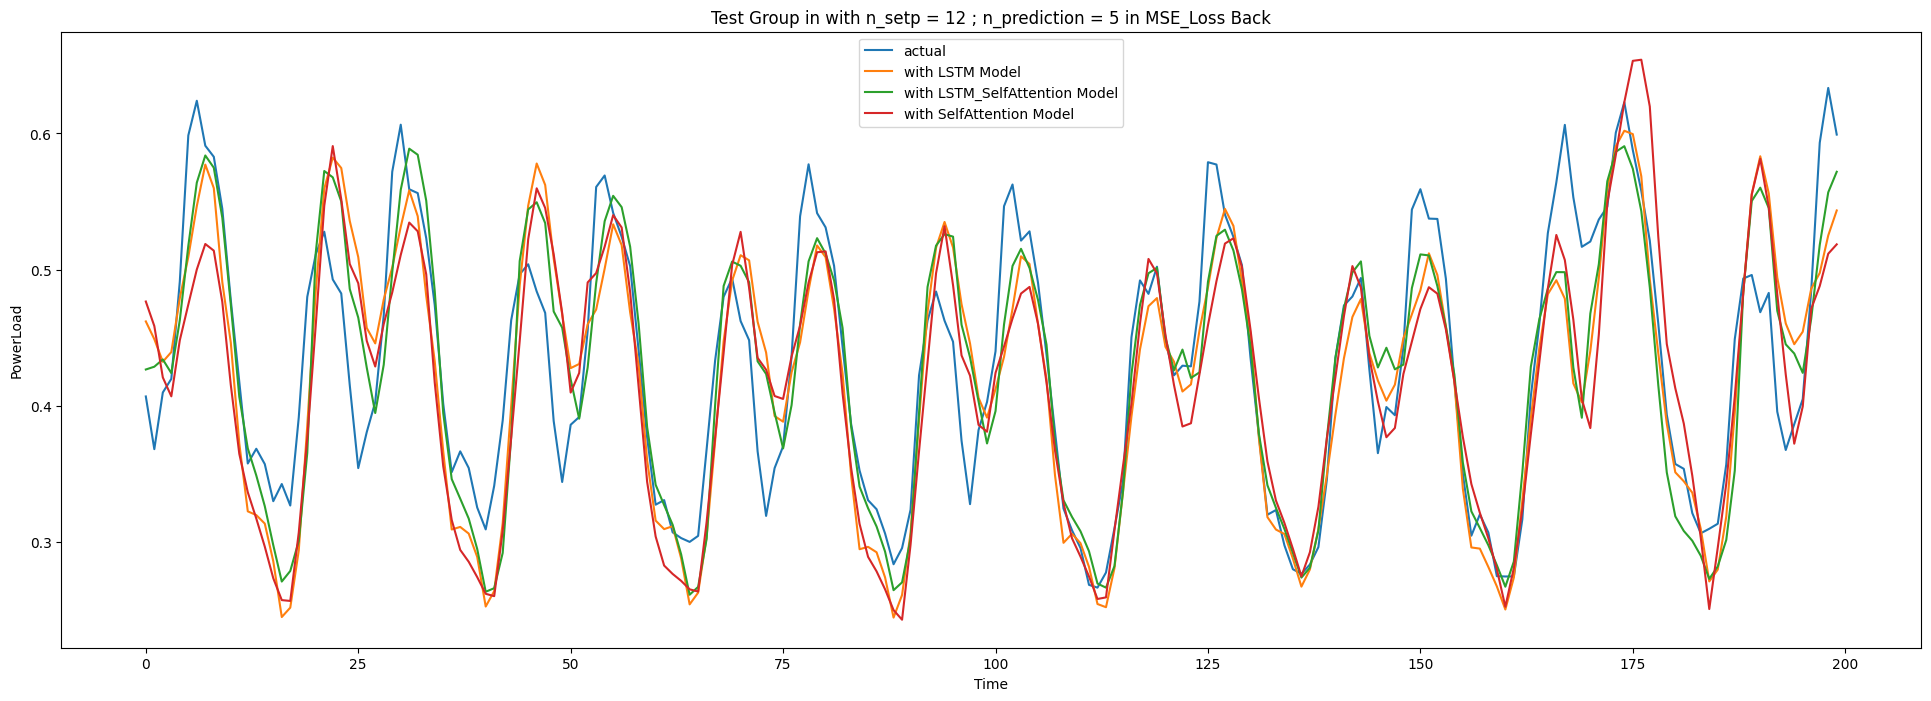

In [ ]:
plt.plot(rY_test3[n1 :n2], label='actual' )
plt.plot(dt_test3[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_test6[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_test9[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Test Group in with n_setp = 12 ; n_prediction = 5 in MSE_Loss Back')
plt.legend()
plt.show()

In [ ]:
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def MAPE(y_true, y_pred):
    actual, pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


RMSE OF LSTM MODEL : 0.02
RMSE OF LSTM MODEL : 0.04
RMSE OF LSTM MODEL : 0.04
RMSE OF Self-Attention MODEL : 0.03
RMSE OF Self-Attention MODEL : 0.05
RMSE OF Self-Attention MODEL : 0.05
RMSE OF LSTM_SA MODEL : 0.02
RMSE OF LSTM_SA MODEL : 0.04
RMSE OF LSTM_SA MODEL : 0.04


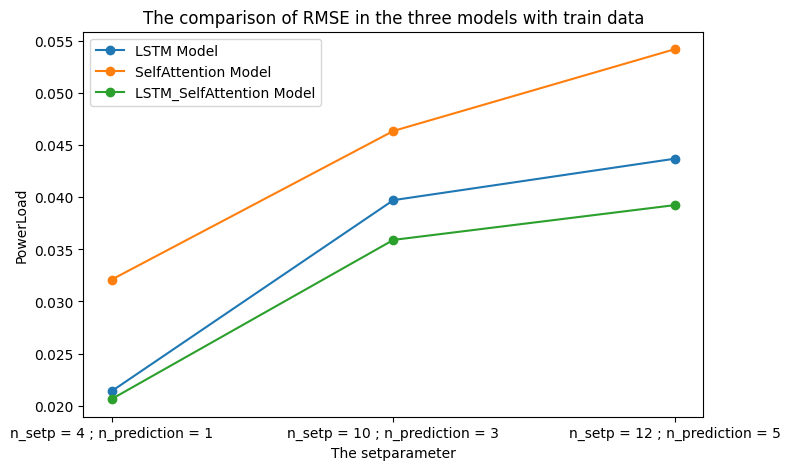

In [ ]:
LSTM_RMSE_1 = RMSE(rY_train1[n1 :n2], dt_train1[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_1:.4f}")
LSTM_RMSE_2 = RMSE(rY_train2[n1 :n2], dt_train2[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_2:.4f}")
LSTM_RMSE_3 = RMSE(rY_train3[n1 :n2], dt_train3[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_3:.4f}")

SA_RMSE_1 = RMSE(rY_train1[n1 :n2], dt_train7[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_1:.4f}")
SA_RMSE_2 = RMSE(rY_train2[n1 :n2], dt_train8[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_2:.4f}")
SA_RMSE_3 = RMSE(rY_train3[n1 :n2], dt_train9[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_3:.4f}")

LSTM_SA_RMSE_1 = RMSE(rY_train1[n1 :n2], dt_train4[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_1:.4f}")
LSTM_SA_RMSE_2 = RMSE(rY_train2[n1 :n2], dt_train5[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_2:.4f}")
LSTM_SA_RMSE_3 = RMSE(rY_train3[n1 :n2], dt_train6[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_3:.4f}")

L = [LSTM_RMSE_1,LSTM_RMSE_2,LSTM_RMSE_3]
S = [SA_RMSE_1,SA_RMSE_2,SA_RMSE_3]
LS = [LSTM_SA_RMSE_1,LSTM_SA_RMSE_2,LSTM_SA_RMSE_3]

group = ["n_setp = 4 ; n_prediction = 1","n_setp = 10 ; n_prediction = 3","n_setp = 12 ; n_prediction = 5"]
plt.figure(figsize=(8,5))
plt.plot(group,L, label='LSTM Model', marker="o")
plt.plot(group,S, label='SelfAttention Model', marker="o")
plt.plot(group,LS, label='LSTM_SelfAttention Model', marker="o")
plt.xlabel('The setparameter')
plt.ylabel('PowerLoad')
plt.title('The comparison of RMSE in the three models with train data')
plt.legend()
plt.show()

MAPE OF LSTM MODEL in with n_setp = 4 ; n_prediction = 1 : 3.97 %
MAPE OF LSTM MODEL in with n_setp = 10 ; n_prediction = 3 : 6.71 %
MAPE OF LSTM MODEL in with n_setp = 12 ; n_prediction = 5 : 8.19 %
MAPE OF Self-Attention MODEL in with n_setp = 4 ; n_prediction = 1 : 5.16 %
MAPE OF Self-Attention MODEL in with n_setp = 10 ; n_prediction = 3 : 8.10 %
MAPE OF Self-Attention MODEL in with n_setp = 12 ; n_prediction = 5 : 10.93 %
MAPE OF LSTM_SA MODEL in with n_setp = 4 ; n_prediction = 1 : 3.63 %
MAPE OF LSTM_SA MODEL in with n_setp = 10 ; n_prediction = 3 : 6.49 %
MAPE OF LSTM_SA MODEL in with n_setp = 12 ; n_prediction = 5 : 7.95 %


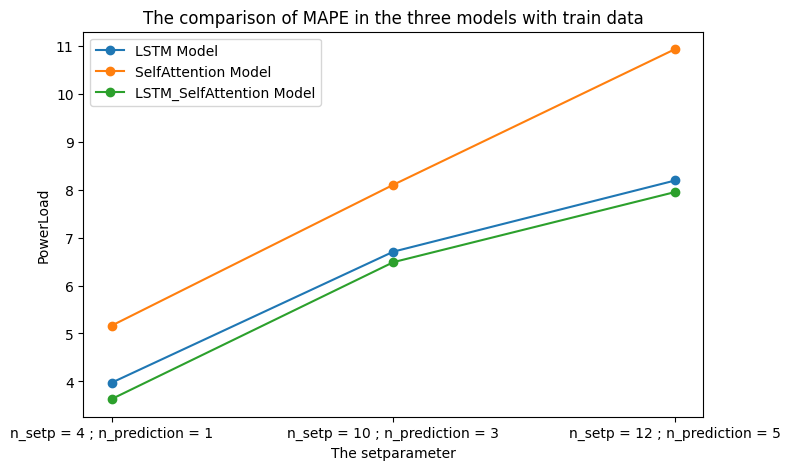

In [ ]:
LSTM_MAPE_1 = MAPE(rY_train1[n1 :n2], dt_train1[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 4 ; n_prediction = 1 : {LSTM_MAPE_1:.4f} %")
LSTM_MAPE_2 = MAPE(rY_train2[n1 :n2], dt_train2[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 10 ; n_prediction = 3 : {LSTM_MAPE_2:.4f} %")
LSTM_MAPE_3 = MAPE(rY_train3[n1 :n2], dt_train3[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 12 ; n_prediction = 5 : {LSTM_MAPE_3:.4f} %")

SA_MAPE_1 = MAPE(rY_train1[n1 :n2], dt_train7[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 4 ; n_prediction = 1 : {SA_MAPE_1:.4f} %")
SA_MAPE_2 = MAPE(rY_train2[n1 :n2], dt_train8[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 10 ; n_prediction = 3 : {SA_MAPE_2:.4f} %")
SA_MAPE_3 = MAPE(rY_train3[n1 :n2], dt_train9[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 12 ; n_prediction = 5 : {SA_MAPE_3:.4f} %")

LSTM_SA_MAPE_1 = MAPE(rY_train1[n1 :n2], dt_train4[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 4 ; n_prediction = 1 : {LSTM_SA_MAPE_1:.4f} %")
LSTM_SA_MAPE_2 = MAPE(rY_train2[n1 :n2], dt_train5[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 10 ; n_prediction = 3 : {LSTM_SA_MAPE_2:.4f} %")
LSTM_SA_MAPE_3 = MAPE(rY_train3[n1 :n2], dt_train6[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 12 ; n_prediction = 5 : {LSTM_SA_MAPE_3:.4f} %")

L = [LSTM_MAPE_1,LSTM_MAPE_2,LSTM_MAPE_3]
S = [SA_MAPE_1,SA_MAPE_2,SA_MAPE_3]
LS = [LSTM_SA_MAPE_1,LSTM_SA_MAPE_2,LSTM_SA_MAPE_3]

group = ["n_setp = 4 ; n_prediction = 1","n_setp = 10 ; n_prediction = 3","n_setp = 12 ; n_prediction = 5"]
plt.figure(figsize=(8,5))
plt.plot(group,L, label='LSTM Model', marker="o")
plt.plot(group,S, label='SelfAttention Model', marker="o")
plt.plot(group,LS, label='LSTM_SelfAttention Model', marker="o")
plt.xlabel('The setparameter')
plt.ylabel('PowerLoad')
plt.title('The comparison of MAPE in the three models with train data')
plt.legend()
plt.show()

RMSE OF LSTM MODEL : 0.03
RMSE OF LSTM MODEL : 0.04
RMSE OF LSTM MODEL : 0.05
RMSE OF Self-Attention MODEL : 0.03
RMSE OF Self-Attention MODEL : 0.04
RMSE OF Self-Attention MODEL : 0.06
RMSE OF LSTM_SA MODEL : 0.03
RMSE OF LSTM_SA MODEL : 0.04
RMSE OF LSTM_SA MODEL : 0.05


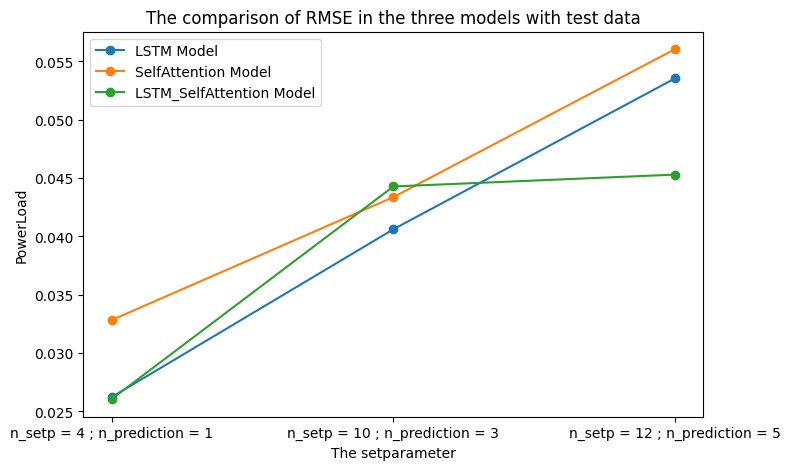

In [ ]:
LSTM_RMSE_1 = RMSE(rY_test1[n1 :n2], dt_test1[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_1:.4f}")
LSTM_RMSE_2 = RMSE(rY_test2[n1 :n2], dt_test2[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_2:.4f}")
LSTM_RMSE_3 = RMSE(rY_test3[n1 :n2], dt_test3[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_3:.4f}")

SA_RMSE_1 = RMSE(rY_test1[n1 :n2], dt_test7[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_1:.4f}")
SA_RMSE_2 = RMSE(rY_test2[n1 :n2], dt_test8[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_2:.4f}")
SA_RMSE_3 = RMSE(rY_test3[n1 :n2], dt_test9[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_3:.4f}")

LSTM_SA_RMSE_1 = RMSE(rY_test1[n1 :n2], dt_test4[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_1:.4f}")
LSTM_SA_RMSE_2 = RMSE(rY_test2[n1 :n2], dt_test5[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_2:.4f}")
LSTM_SA_RMSE_3 = RMSE(rY_test3[n1 :n2], dt_test6[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_3:.4f}")

L = [LSTM_RMSE_1,LSTM_RMSE_2,LSTM_RMSE_3]
S = [SA_RMSE_1,SA_RMSE_2,SA_RMSE_3]
LS = [LSTM_SA_RMSE_1,LSTM_SA_RMSE_2,LSTM_SA_RMSE_3]

group = ["n_setp = 4 ; n_prediction = 1","n_setp = 10 ; n_prediction = 3","n_setp = 12 ; n_prediction = 5"]
plt.figure(figsize=(8,5))
plt.plot(group,L, label='LSTM Model', marker="o")
plt.plot(group,S, label='SelfAttention Model', marker="o")
plt.plot(group,LS, label='LSTM_SelfAttention Model', marker="o")
plt.xlabel('The setparameter')
plt.ylabel('PowerLoad')
plt.title('The comparison of RMSE in the three models with test data')
plt.legend()
plt.show()

MAPE OF LSTM MODEL in with n_setp = 4 ; n_prediction = 1 : 4.65 %
MAPE OF LSTM MODEL in with n_setp = 10 ; n_prediction = 3 : 6.48 %
MAPE OF LSTM MODEL in with n_setp = 12 ; n_prediction = 5 : 9.67 %
MAPE OF Self-Attention MODEL in with n_setp = 4 ; n_prediction = 1 : 6.02 %
MAPE OF Self-Attention MODEL in with n_setp = 10 ; n_prediction = 3 : 8.00 %
MAPE OF Self-Attention MODEL in with n_setp = 12 ; n_prediction = 5 : 10.39 %
MAPE OF LSTM_SA MODEL in with n_setp = 4 ; n_prediction = 1 : 4.48 %
MAPE OF LSTM_SA MODEL in with n_setp = 10 ; n_prediction = 3 : 7.28 %
MAPE OF LSTM_SA MODEL in with n_setp = 12 ; n_prediction = 5 : 8.05 %


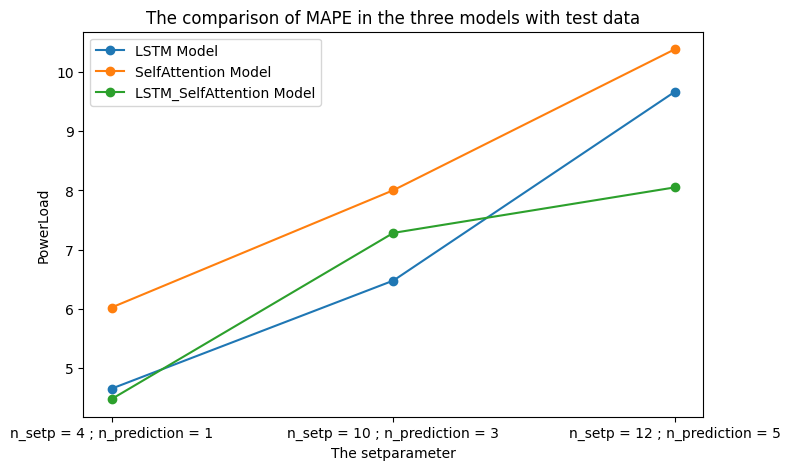

In [ ]:
LSTM_MAPE_1 = MAPE(rY_test1[n1 :n2], dt_test1[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 4 ; n_prediction = 1 : {LSTM_MAPE_1:.4f} %")
LSTM_MAPE_2 = MAPE(rY_test2[n1 :n2], dt_test2[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 10 ; n_prediction = 3 : {LSTM_MAPE_2:.4f} %")
LSTM_MAPE_3 = MAPE(rY_test3[n1 :n2], dt_test3[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 12 ; n_prediction = 5 : {LSTM_MAPE_3:.4f} %")

SA_MAPE_1 = MAPE(rY_test1[n1 :n2], dt_test7[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 4 ; n_prediction = 1 : {SA_MAPE_1:.4f} %")
SA_MAPE_2 = MAPE(rY_test2[n1 :n2], dt_test8[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 10 ; n_prediction = 3 : {SA_MAPE_2:.4f} %")
SA_MAPE_3 = MAPE(rY_test3[n1 :n2], dt_test9[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 12 ; n_prediction = 5 : {SA_MAPE_3:.4f} %")

LSTM_SA_MAPE_1 = MAPE(rY_test1[n1 :n2], dt_test4[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 4 ; n_prediction = 1 : {LSTM_SA_MAPE_1:.4f} %")
LSTM_SA_MAPE_2 = MAPE(rY_test2[n1 :n2], dt_test5[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 10 ; n_prediction = 3 : {LSTM_SA_MAPE_2:.4f} %")
LSTM_SA_MAPE_3 = MAPE(rY_test3[n1 :n2], dt_test6[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 12 ; n_prediction = 5 : {LSTM_SA_MAPE_3:.4f} %")

L = [LSTM_MAPE_1,LSTM_MAPE_2,LSTM_MAPE_3]
S = [SA_MAPE_1,SA_MAPE_2,SA_MAPE_3]
LS = [LSTM_SA_MAPE_1,LSTM_SA_MAPE_2,LSTM_SA_MAPE_3]

group = ["n_setp = 4 ; n_prediction = 1","n_setp = 10 ; n_prediction = 3","n_setp = 12 ; n_prediction = 5"]
plt.figure(figsize=(8,5))
plt.plot(group,L, label='LSTM Model', marker="o")
plt.plot(group,S, label='SelfAttention Model', marker="o")
plt.plot(group,LS, label='LSTM_SelfAttention Model', marker="o")
plt.xlabel('The setparameter')
plt.ylabel('PowerLoad')
plt.title('The comparison of MAPE in the three models with test data')
plt.legend()
plt.show()